# Non-Parametric Product Life Cycle Modeling

In this notebook we present an example of how to use a combination of bayesian hierarchical models and the non-parametric methods , namely bayesian additive trees ([BART](https://www.pymc.io/projects/bart/en/latest/)), to model the product life cycles. This approach is motivated by previous work in cohort analysis, see [here](https://juanitorduz.github.io/revenue_retention/). 

As a case study we use the Google search index (trends) data for iPhones worldwide. We use the data of four different models to predict the development of the latest iPhone. The model presented for this specific example can be easily extended for other products and product life cycles structures.

## Prepare Notebook

In [1]:
import arviz as az
import holidays
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import preliz as pz
import pymc as pm
import pymc_bart as pmb
import pytensor.tensor as pt
import seaborn as sns
from pymc_bart.split_rules import ContinuousSplitRule, OneHotSplitRule, SubsetSplitRule

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
seed: int = sum(map(ord, "iphone_trends"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

## Read Data

We provide the data downloaded from Google Trends for the following search terms (weekly granularity):

![](../images/trends_iphone.png)

In [3]:
raw_df = pd.read_csv("../data/iphone_trends.csv", parse_dates=["week"])

raw_df.tail()

week  iphone_11  iphone_12  iphone_13  iphone_14  iphone_15
256 2023-10-22         10         10         14         16         23
257 2023-10-29         10          9         13         15         22
258 2023-11-05         11         10         15         17         22
259 2023-11-12         11         10         16         17         24
260 2023-11-19         12         11         17         17         24

We see a clear structure in the searches development for each model:

- Steep peak at the beginning of the product life cycle (maximum on the release week)
- A slow long term decay with a mild yearly seasonality.

In order to capture the peak at the beginning of the product life cycle we collect the release data for such iPhone models:

In [4]:
releases_df = pd.DataFrame(
    data=[
        {"model": "iphone_11", "release_date": "September 20, 2019"},
        {"model": "iphone_12", "release_date": "October 23, 2020"},
        {"model": "iphone_13", "release_date": "September 24, 2021"},
        {"model": "iphone_14", "release_date": "September 16, 2022"},
        {"model": "iphone_15", "release_date": "September 22, 2023"},
    ]
)

# We use the same week-starting date as the Google Trends data
release_dates_df = releases_df.assign(
    release_week=lambda x: (
        pd.to_datetime(x["release_date"]).dt.to_period("W-SAT").dt.start_time
        - pd.DateOffset(days=7)
    )
)

release_dates_df.head()

model        release_date release_week
0  iphone_11  September 20, 2019   2019-09-08
1  iphone_12    October 23, 2020   2020-10-11
2  iphone_13  September 24, 2021   2021-09-12
3  iphone_14  September 16, 2022   2022-09-04
4  iphone_15  September 22, 2023   2023-09-10

## Feature Engineering

To start, we collect two holiday events that are clear from the image above: Black Friday and Christmas.

In [5]:
holidays_list = ["Christmas Day", "Thanksgiving"]

holidays_df = (
    pd.DataFrame.from_dict(
        data=holidays.country_holidays(
            country="US", years=[2019, 2020, 2021, 2022, 2023, 2024]
        ),
        orient="index",
        columns=["holiday"],
    )
    .query("holiday in @holidays_list")
    .reset_index(drop=False)
    .rename(columns={"index": "date"})
    .assign(
        week=lambda x: pd.to_datetime(x["date"]).dt.to_period("W-SAT").dt.start_time
    )
)

holidays_df.head(12)

date        holiday       week
0   2019-11-28   Thanksgiving 2019-11-24
1   2019-12-25  Christmas Day 2019-12-22
2   2020-11-26   Thanksgiving 2020-11-22
3   2020-12-25  Christmas Day 2020-12-20
4   2021-11-25   Thanksgiving 2021-11-21
5   2021-12-25  Christmas Day 2021-12-19
6   2022-11-24   Thanksgiving 2022-11-20
7   2022-12-25  Christmas Day 2022-12-25
8   2023-11-23   Thanksgiving 2023-11-19
9   2023-12-25  Christmas Day 2023-12-24
10  2024-11-28   Thanksgiving 2024-11-24
11  2024-12-25  Christmas Day 2024-12-22

Next, motivated by the features used in the previous work on [cohort analysis](https://juanitorduz.github.io/revenue_retention/), we create the following features:


- `age`: Number of weeks since the release of the iPhone model relative to today's date.
- `model_age`: Number of weeks since the release of the iPhone model relative to the release of the latest iPhone model. Not that this feature is negative for weeks before the release.
- `is_release_week`: Binary feature indicating if the week is the release week of the iPhone model.
- `month`: Month of the year.

In [6]:
data_df = (
    raw_df.copy()
    .melt(id_vars=["week"], var_name="model", value_name="search")
    .merge(right=release_dates_df, on="model")
    .drop(columns=["release_date"])
    .assign(
        age=lambda x: (x["week"].max() - x["week"]).dt.days / 7,
        model_age=lambda x: (x["week"] - x["release_week"]).dt.days / 7,
        is_release=lambda x: (x["model_age"] == 0).astype(float),
        month=lambda x: x["week"].dt.month,
        # holidays
        is_christmas=lambda x: x["week"]
        .isin(holidays_df.query("holiday == 'Christmas Day'")["week"])
        .astype(float),
        is_thanksgiving=lambda x: x["week"]
        .isin(holidays_df.query("holiday == 'Thanksgiving'")["week"])
        .astype(float),
    )
    .query(
        "model_age >= -50"
    )  # Drop data one year before release (as it is mainly noise)
    .reset_index(drop=True)
)

data_df.head()

week      model  search release_week    age  model_age  is_release  \
0 2018-11-25  iphone_11       0   2019-09-08  260.0      -41.0         0.0   
1 2018-12-02  iphone_11       0   2019-09-08  259.0      -40.0         0.0   
2 2018-12-09  iphone_11       0   2019-09-08  258.0      -39.0         0.0   
3 2018-12-16  iphone_11       0   2019-09-08  257.0      -38.0         0.0   
4 2018-12-23  iphone_11       0   2019-09-08  256.0      -37.0         0.0   

   month  is_christmas  is_thanksgiving  
0     11           0.0              0.0  
1     12           0.0              0.0  
2     12           0.0              0.0  
3     12           0.0              0.0  
4     12           0.0              0.0

## EDA

We plot the data for each iPhone model:

Text(0.5, 1.0, 'Google Trends for iPhone Models (Worldwide)')

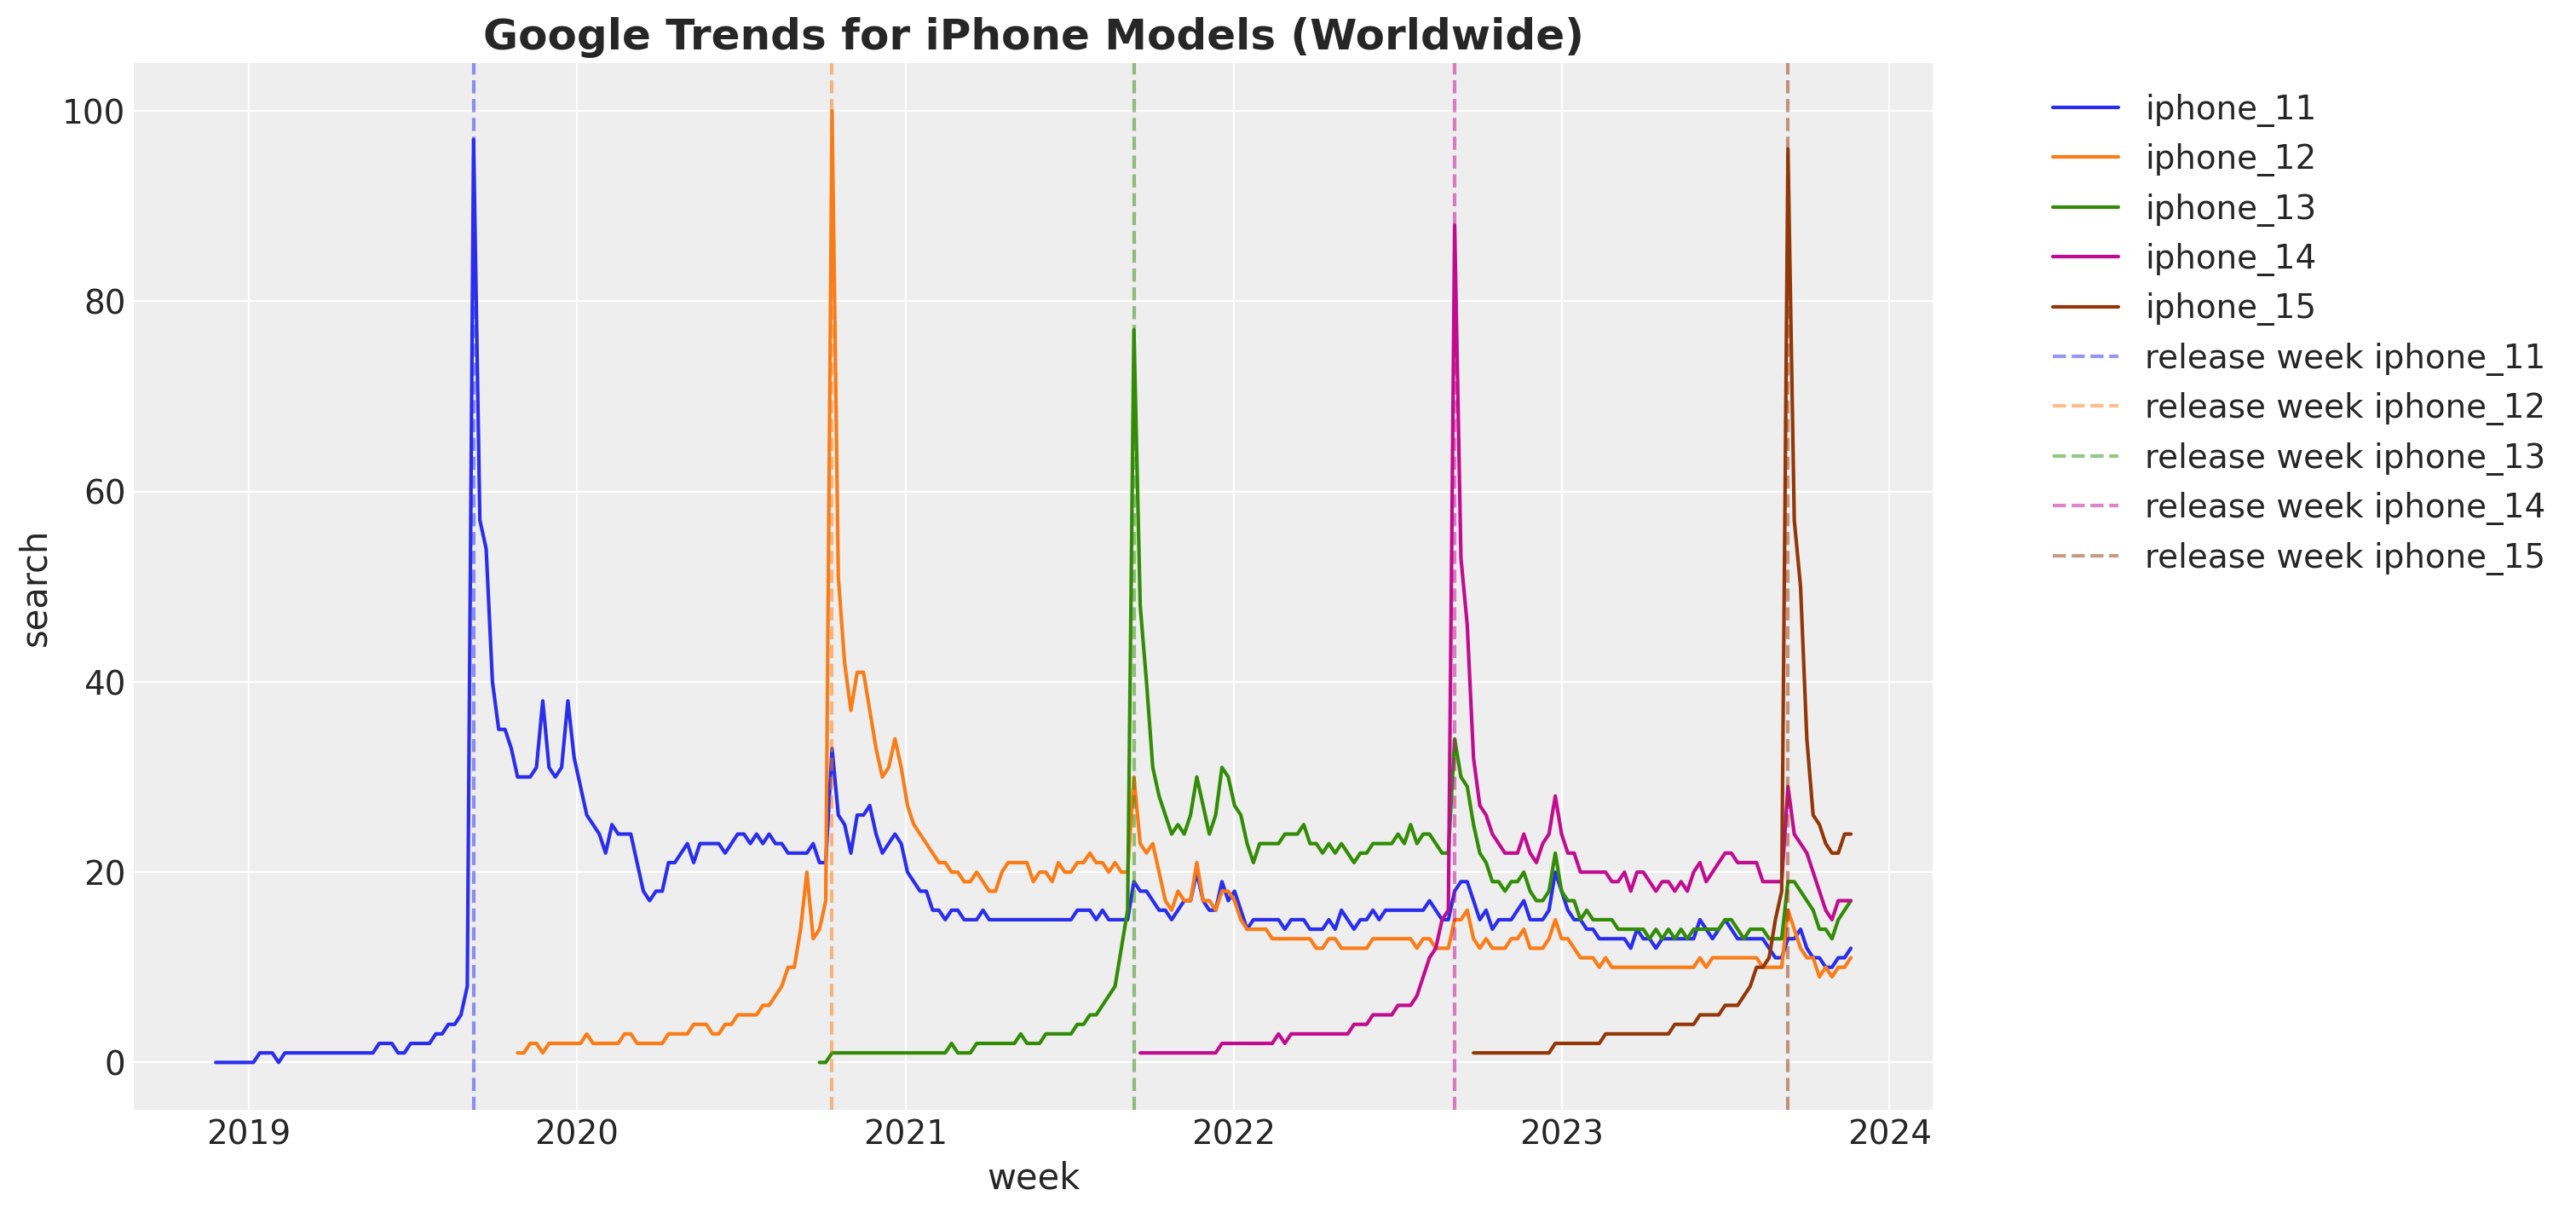

In [7]:
fig, ax = plt.subplots(figsize=(15, 7))

sns.lineplot(
    data=data_df,
    x="week",
    y="search",
    hue="model",
    ax=ax,
)

for i, model in enumerate(release_dates_df["model"]):
    release_week = release_dates_df.query(f"model == '{model}'")["release_week"].item()
    ax.axvline(
        release_week,
        color=f"C{i}",
        linestyle="--",
        alpha=0.5,
        label=f"release week {model}",
    )

ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
ax.set_title(
    label="Google Trends for iPhone Models (Worldwide)", fontsize=18, fontweight="bold"
)

We do see how the peak maximum coincides with the release date.

Note that all of the models have a similar structure, however the maximum and decay forms differ from model to model. This motivates the use of a hierarchical model.

On the other hand, if we plot the search index in a heat map we doo see the immediate similarity to th cohort analysis problem where we use `age` and `cohort` age as key futures to model the revenue and retention:

Text(0.5, 1.0, 'Google Trends for iPhone Models (Worldwide)')

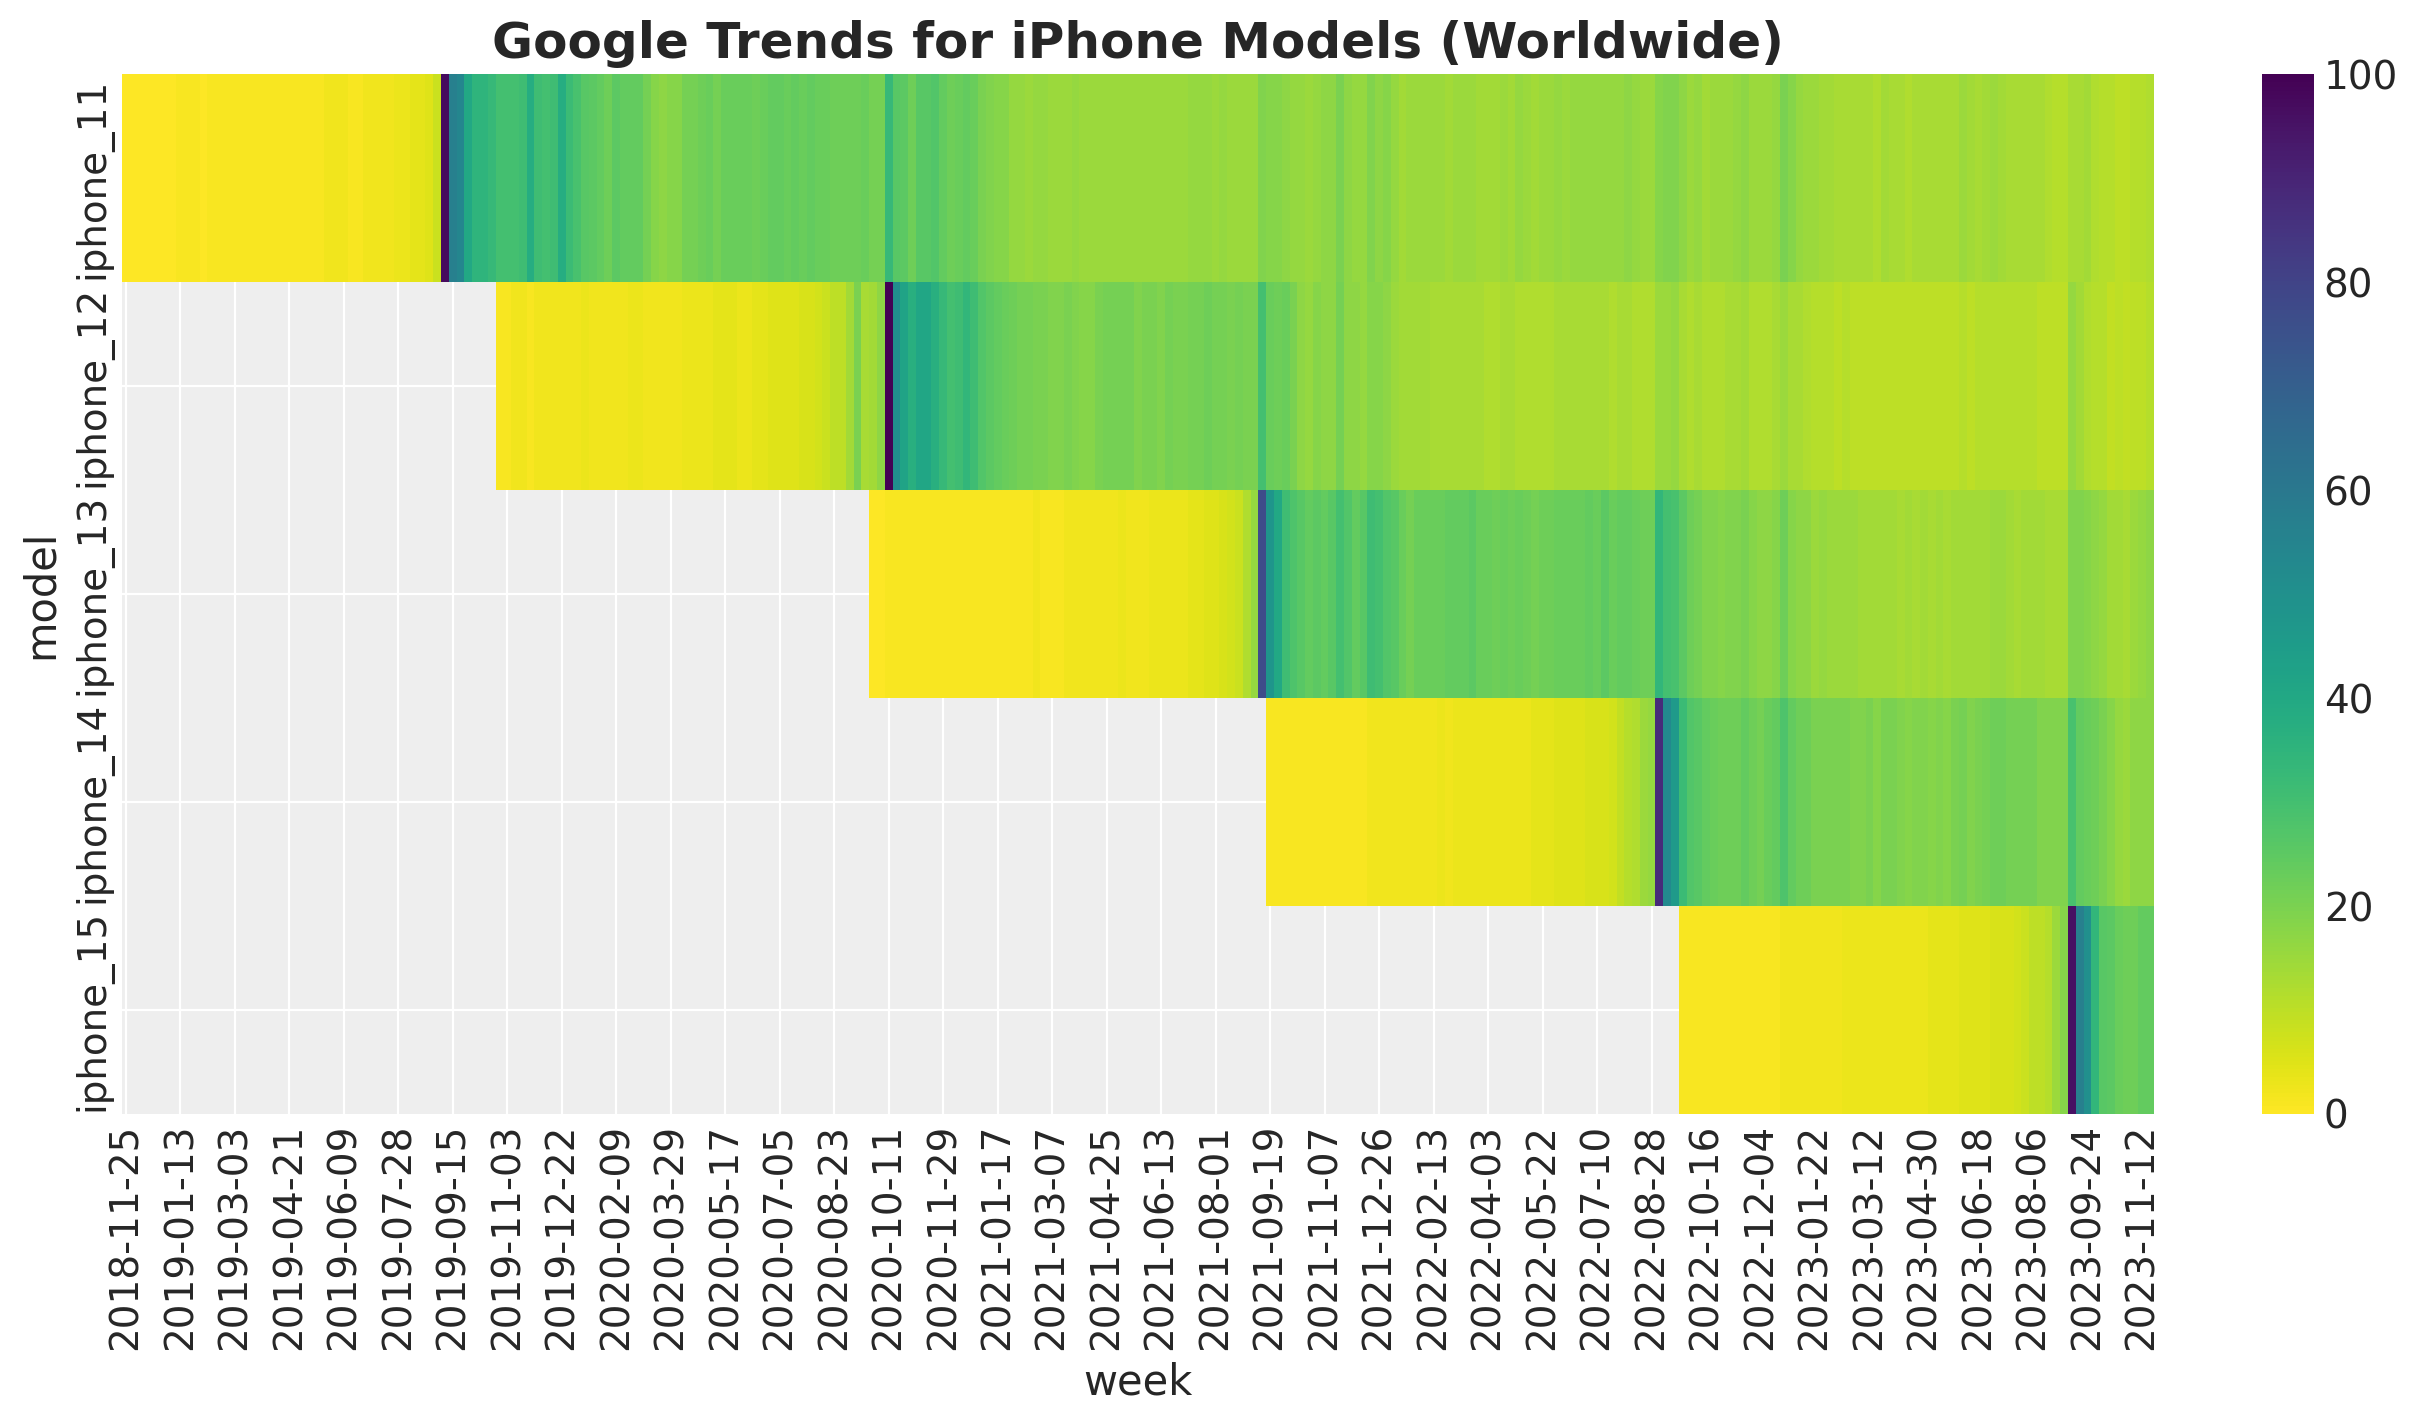

In [8]:
fig, ax = plt.subplots()
(
    data_df.assign(week=lambda x: x["week"].dt.date)[["model", "week", "search"]]
    .pivot_table(index="model", columns="week", values="search")
    .pipe(
        (sns.heatmap, "data"),
        cmap="viridis_r",
        ax=ax,
    )
)
ax.set_title(
    label="Google Trends for iPhone Models (Worldwide)", fontsize=18, fontweight="bold"
)

This motivates the use of BART as a non-parametric component to model seasonal and long term behavior of the search index.

**Remark:** This is of course not the only possibility. We could for example use (hierarchical) Gaussian processes.

## Prepare Data

We now prepare the data for the model.

In [9]:
# model for the holdout data
test_model = "iphone_15"

train_df = data_df.query(f"model != '{test_model}'")
test_df = data_df.query(f"model == '{test_model}'")

In [10]:
train_obs = train_df.index.to_numpy()
train_iphone_model_idx, train_iphone_model = train_df["model"].factorize(sort=True)
train_month_idx, train_month = train_df["month"].factorize(sort=True)
train_age = train_df["age"].to_numpy()
train_model_age = train_df["model_age"].to_numpy()
train_is_release = train_df["is_release"].to_numpy()
features = ["age", "model_age", "month", "is_christmas", "is_thanksgiving"]
x_train = train_df[features]
train_search = train_df["search"].to_numpy()

## Model Specification

### Main Idea

The main idea is to model the search index through a negative binomial likelihood where the mean is the sum of the release phase plus the long term decay. For the release phase we use a non-symmetric [Gaussian bump function](https://juanitorduz.github.io/bump_func/) while for the long term decay we use a BART model.

**Remark**: We use the recommended parametrization for the negative binomial distribution, see [here](https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations#story-when-the-generic-prior-fails-the-case-of-the-negative-binomial).

**Remark:** We weight the $\alpha$ parameter in the likelihood to place more importance on the search index values closer to the release date. The motivation is that we are often interested in this first phase much more than the relatively stable decay (see [here](https://discourse.pymc.io/t/how-to-add-weights-to-data-in-bayesian-linear-regression/8362)).

### Mathematical Formulation

Here are the main ingredients of the model:

$$
\begin{align*}
\beta^{[m]}_{\text{release}} & \sim \text{HalfNormal}(\sigma_{\beta}) \\
\ell^{[m]}_{\pm} & \sim \text{HalfNormal}(\sigma_{\ell}) \\
\mu_{\text{release}} & = \beta^{[m]}_{\text{release}} \left( I\{\text{model\_age} \leq 0\} \exp(-{\text{model\_age}^{p_{-}} / \ell^{[m]}_{-}}) + I\{\text{model\_age} \geq 0\} \exp(-{\text{model\_age}^{p_{+}} / \ell^{[m]}_{+}} )  \right)\\
\mu_{\text{decay}} & = \text{BART}(\text{age}, \text{model\_age}, \text{month}, \text{holidays}) \\
\mu & = \mu_{\text{release}} + \mu_{\text{decay}} \\
\alpha & = \frac{1}{\sqrt{\tilde{\alpha}}} \\
\alpha_{\text{weighted}} & = \frac{\alpha}{|\text{model\_age}|} \\
\text{search} & \sim \text{NegativeBinomial}(\mu, \alpha_{\text{weighted}})
\end{align*}
$$

The hierarchical structure is encoded in $\beta{\text{release}}$ and the  $\ell_{\pm}$ which come from a common prior for each model respectively.

I believe this mathematical formulation is not very intuitive, so let's go to the PyMC code:

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-packages/pymc_bart/bart.py:136: UserWarning: Options linear and mix are experimental and still not well tested
Use with caution.
  warnings.warn(


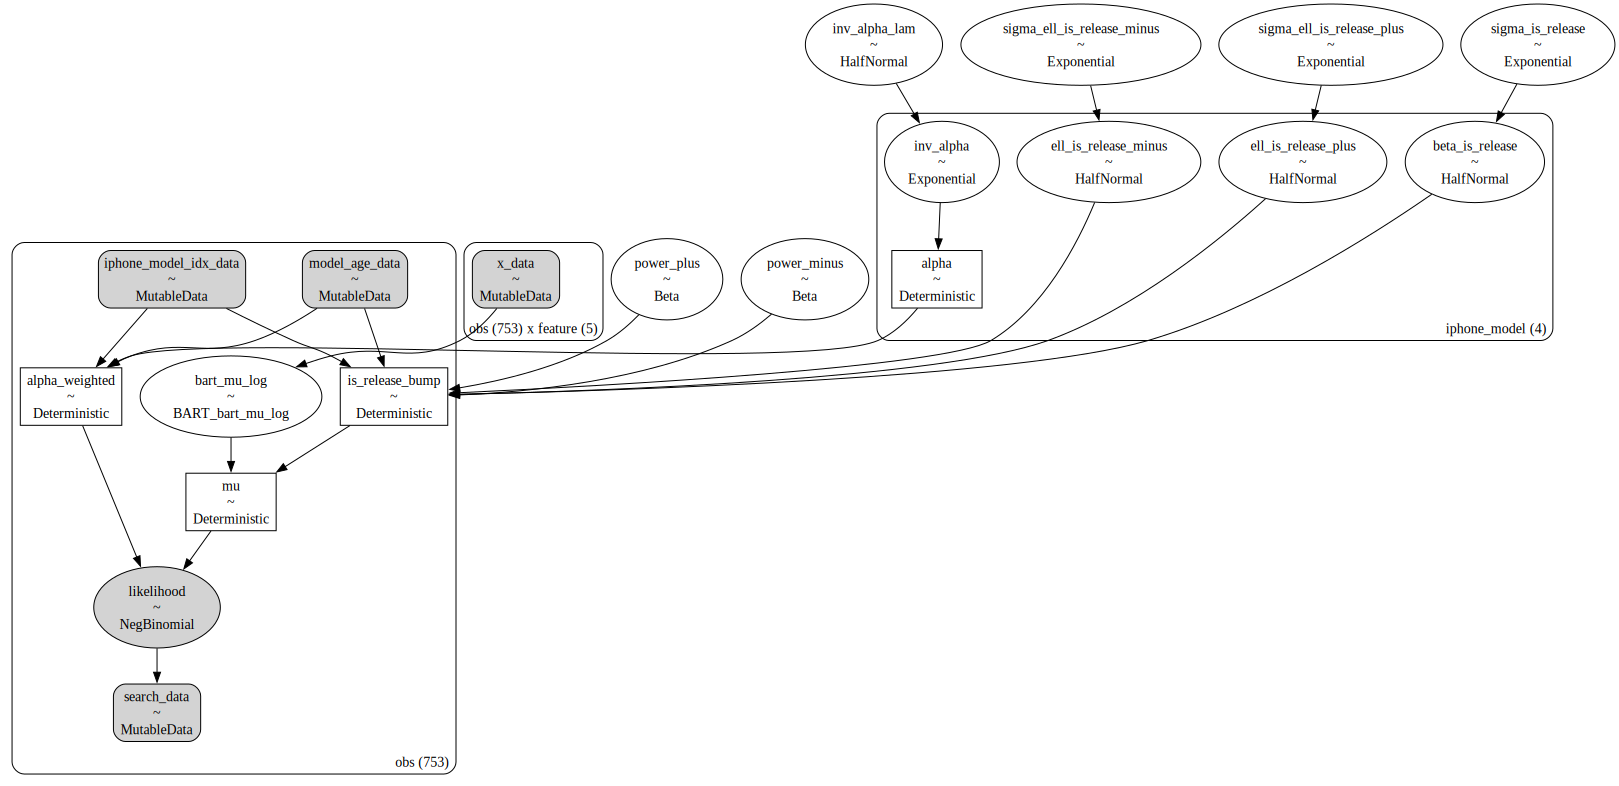

In [11]:
# small number for numerical stability
eps = np.finfo(float).eps

coords = {"month": train_month, "feature": features}

with pm.Model(coords=coords) as model:
    # --- Data Containers ---

    model.add_coord(name="iphone_model", values=train_iphone_model, mutable=True)
    model.add_coord(name="obs", values=train_obs, mutable=True)
    iphone_model_idx_data = pm.MutableData(
        name="iphone_model_idx_data", value=train_iphone_model_idx, dims="obs"
    )
    model_age_data = pm.MutableData(
        name="model_age_data", value=train_model_age, dims="obs"
    )
    x_data = pm.MutableData(name="x_data", value=x_train, dims=("obs", "feature"))
    search_data = pm.MutableData(name="search_data", value=train_search, dims="obs")

    # --- Priors ---

    power_minus = pm.Beta(name="power_minus", alpha=5, beta=15)
    power_plus = pm.Beta(name="power_plus", alpha=5, beta=15)

    sigma_ell_is_release_minus = pm.Exponential(
        name="sigma_ell_is_release_minus", lam=1
    )
    sigma_ell_is_release_plus = pm.Exponential(
        name="sigma_ell_is_release_plus", lam=1 / 4
    )
    sigma_is_release = pm.Exponential(name="sigma_is_release", lam=1 / 100)

    ell_is_release_minus = pm.HalfNormal(
        name="ell_is_release_minus",
        sigma=sigma_ell_is_release_minus,
        dims="iphone_model",
    )

    ell_is_release_plus = pm.HalfNormal(
        name="ell_is_release_plus", sigma=sigma_ell_is_release_plus, dims="iphone_model"
    )

    beta_is_release = pm.HalfNormal(
        name="beta_is_release", sigma=sigma_is_release, dims="iphone_model"
    )

    inv_alpha_lam = pm.HalfNormal(name="inv_alpha_lam", sigma=500)

    inv_alpha = pm.Exponential(name="inv_alpha", lam=inv_alpha_lam, dims="iphone_model")

    bart_mu_log = pmb.BART(
        name="bart_mu_log",
        X=x_data,
        Y=np.log1p(train_search),
        m=100,
        response="mix",
        split_rules=[
            ContinuousSplitRule(),
            ContinuousSplitRule(),
            SubsetSplitRule(),
            OneHotSplitRule(),
            OneHotSplitRule(),
        ],
        dims="obs",
    )

    # --- Parametrization ---

    is_release_bump = pm.Deterministic(
        name="is_release_bump",
        var=beta_is_release[iphone_model_idx_data]
        * (
            (
                (model_age_data < 0)
                * pt.exp(
                    -pt.pow(pt.abs(model_age_data), power_minus)
                    / ell_is_release_minus[iphone_model_idx_data]
                )
            )
            + (
                (model_age_data >= 0)
                * pt.exp(
                    -pt.pow(pt.abs(model_age_data), power_plus)
                    / ell_is_release_plus[iphone_model_idx_data]
                )
            )
        ),
        dims="obs",
    )

    mu = pm.Deterministic(
        name="mu",
        var=pt.exp(bart_mu_log) + is_release_bump,
        dims="obs",
    )

    alpha = pm.Deterministic(
        name="alpha",
        var=1 / (pt.sqrt(inv_alpha) + eps),
        dims="iphone_model",
    )

    alpha_weighted = pm.Deterministic(
        name="alpha_weighted",
        var=alpha[iphone_model_idx_data] / (pt.abs(model_age_data) + 1),
        dims="obs",
    )

    # --- Likelihood ---

    _ = pm.NegativeBinomial(
        name="likelihood",
        mu=mu,
        alpha=alpha_weighted,
        observed=search_data,
        dims="obs",
    )

pm.model_to_graphviz(model=model)

We can take a look into some of the prior distributions for the Gaussian bump parameters:

Text(0.5, 1.0, '$\\sigma_{\\ell}$')

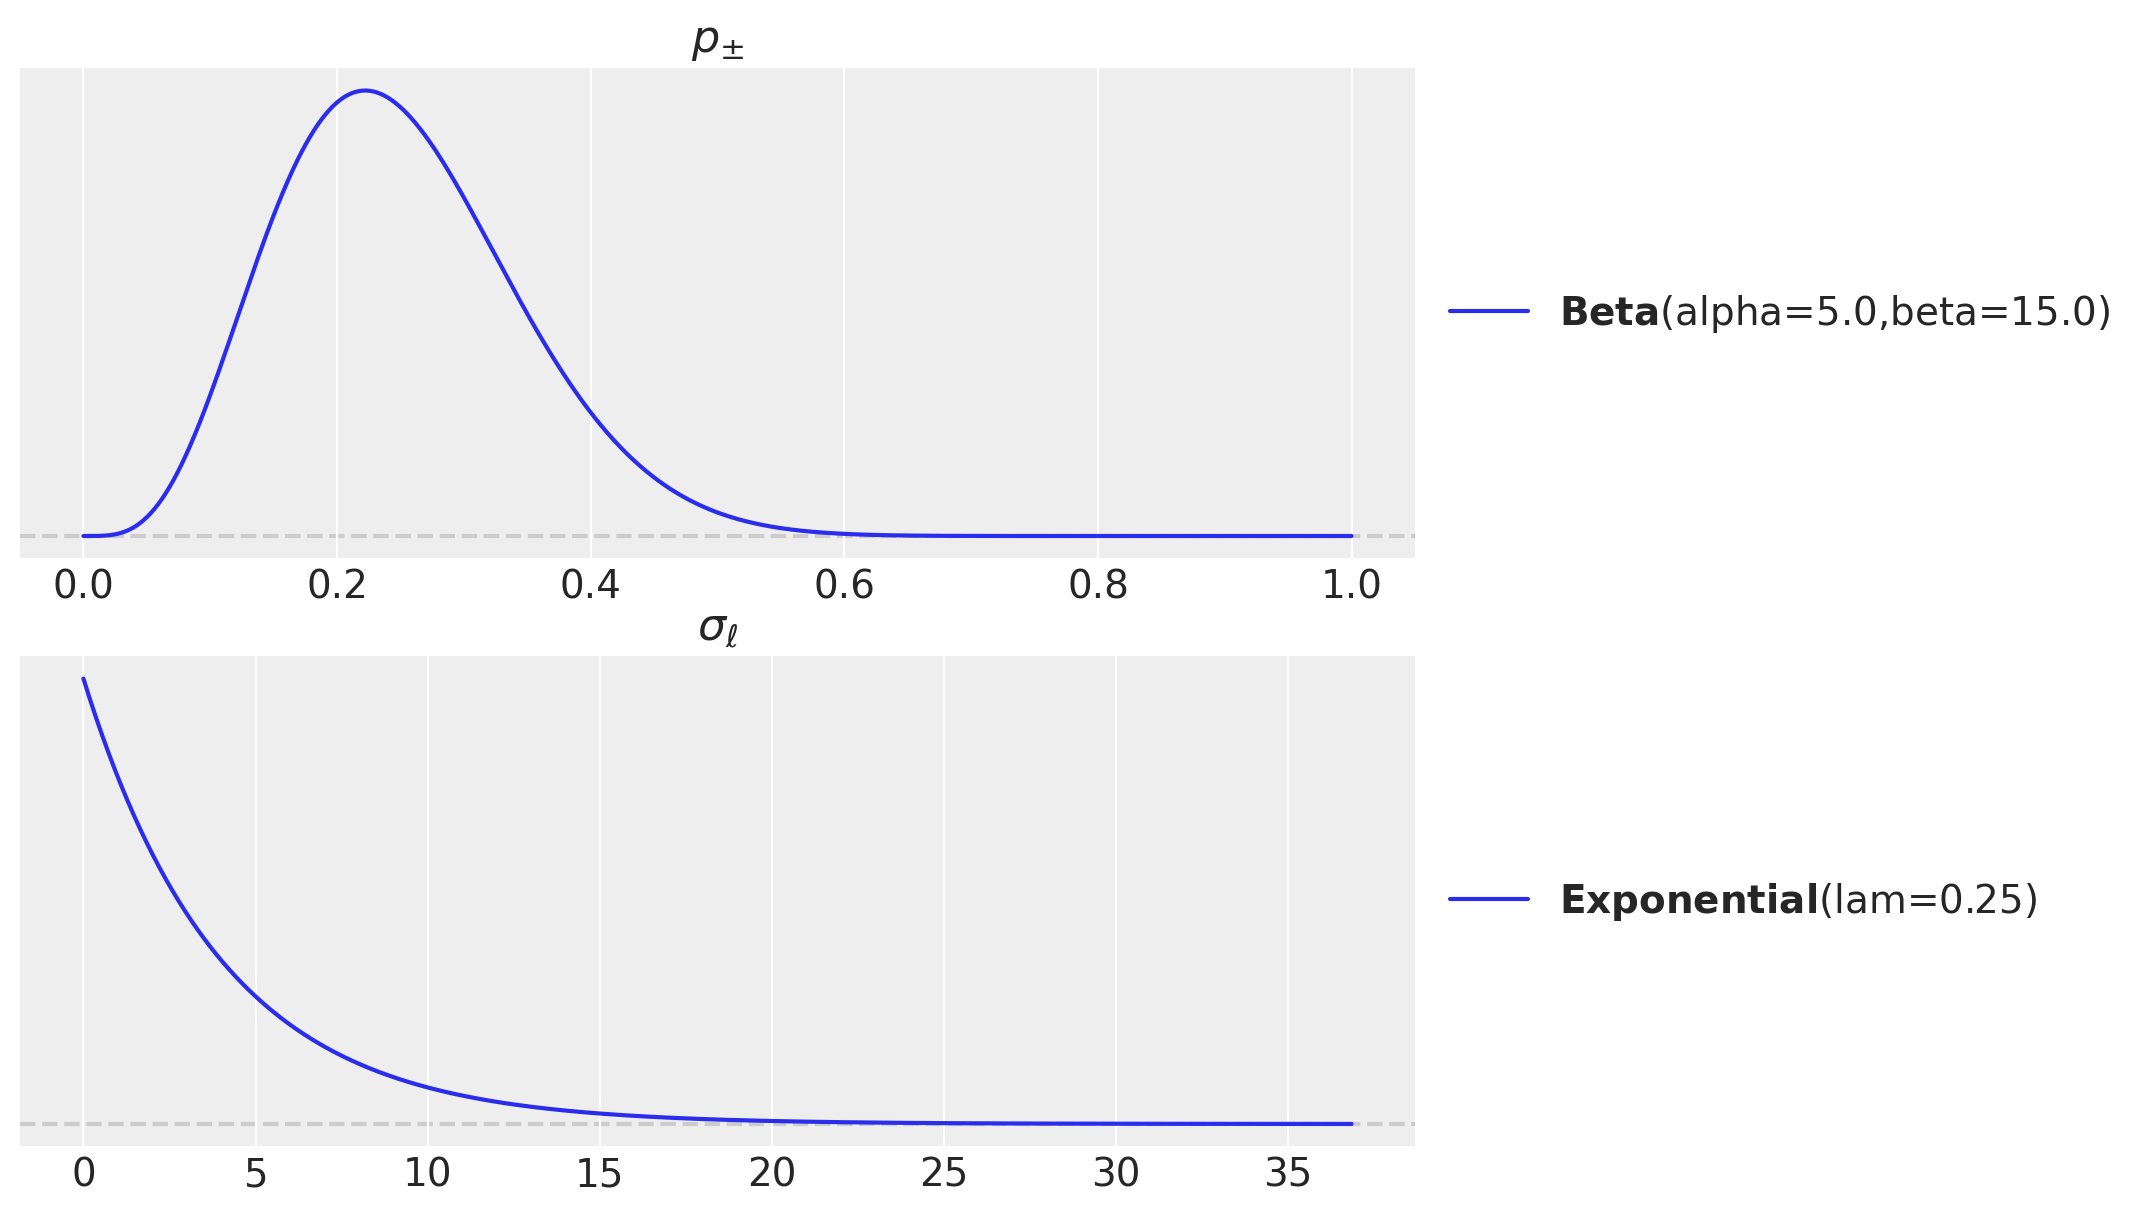

In [12]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(9, 7), sharex=False, sharey=False, layout="constrained"
)
pz.Beta(alpha=5, beta=15).plot_pdf(ax=ax[0])
ax[0].set_title(r"$p_{\pm}$")
pz.Exponential(lam=1 / 4).plot_pdf(ax=ax[1])
ax[1].set_title(r"$\sigma_{\ell}$")

## Prior Predictive

Let's start with the prior predictive distribution to check the feasibility of the priors and the model specification:

In [13]:
with model:
    prior_predictive = pm.sample_prior_predictive(samples=1_000, random_seed=rng)

Sampling: [bart_mu_log, beta_is_release, ell_is_release_minus, ell_is_release_plus, inv_alpha, inv_alpha_lam, likelihood, power_minus, power_plus, sigma_ell_is_release_minus, sigma_ell_is_release_plus, sigma_is_release]


[None]

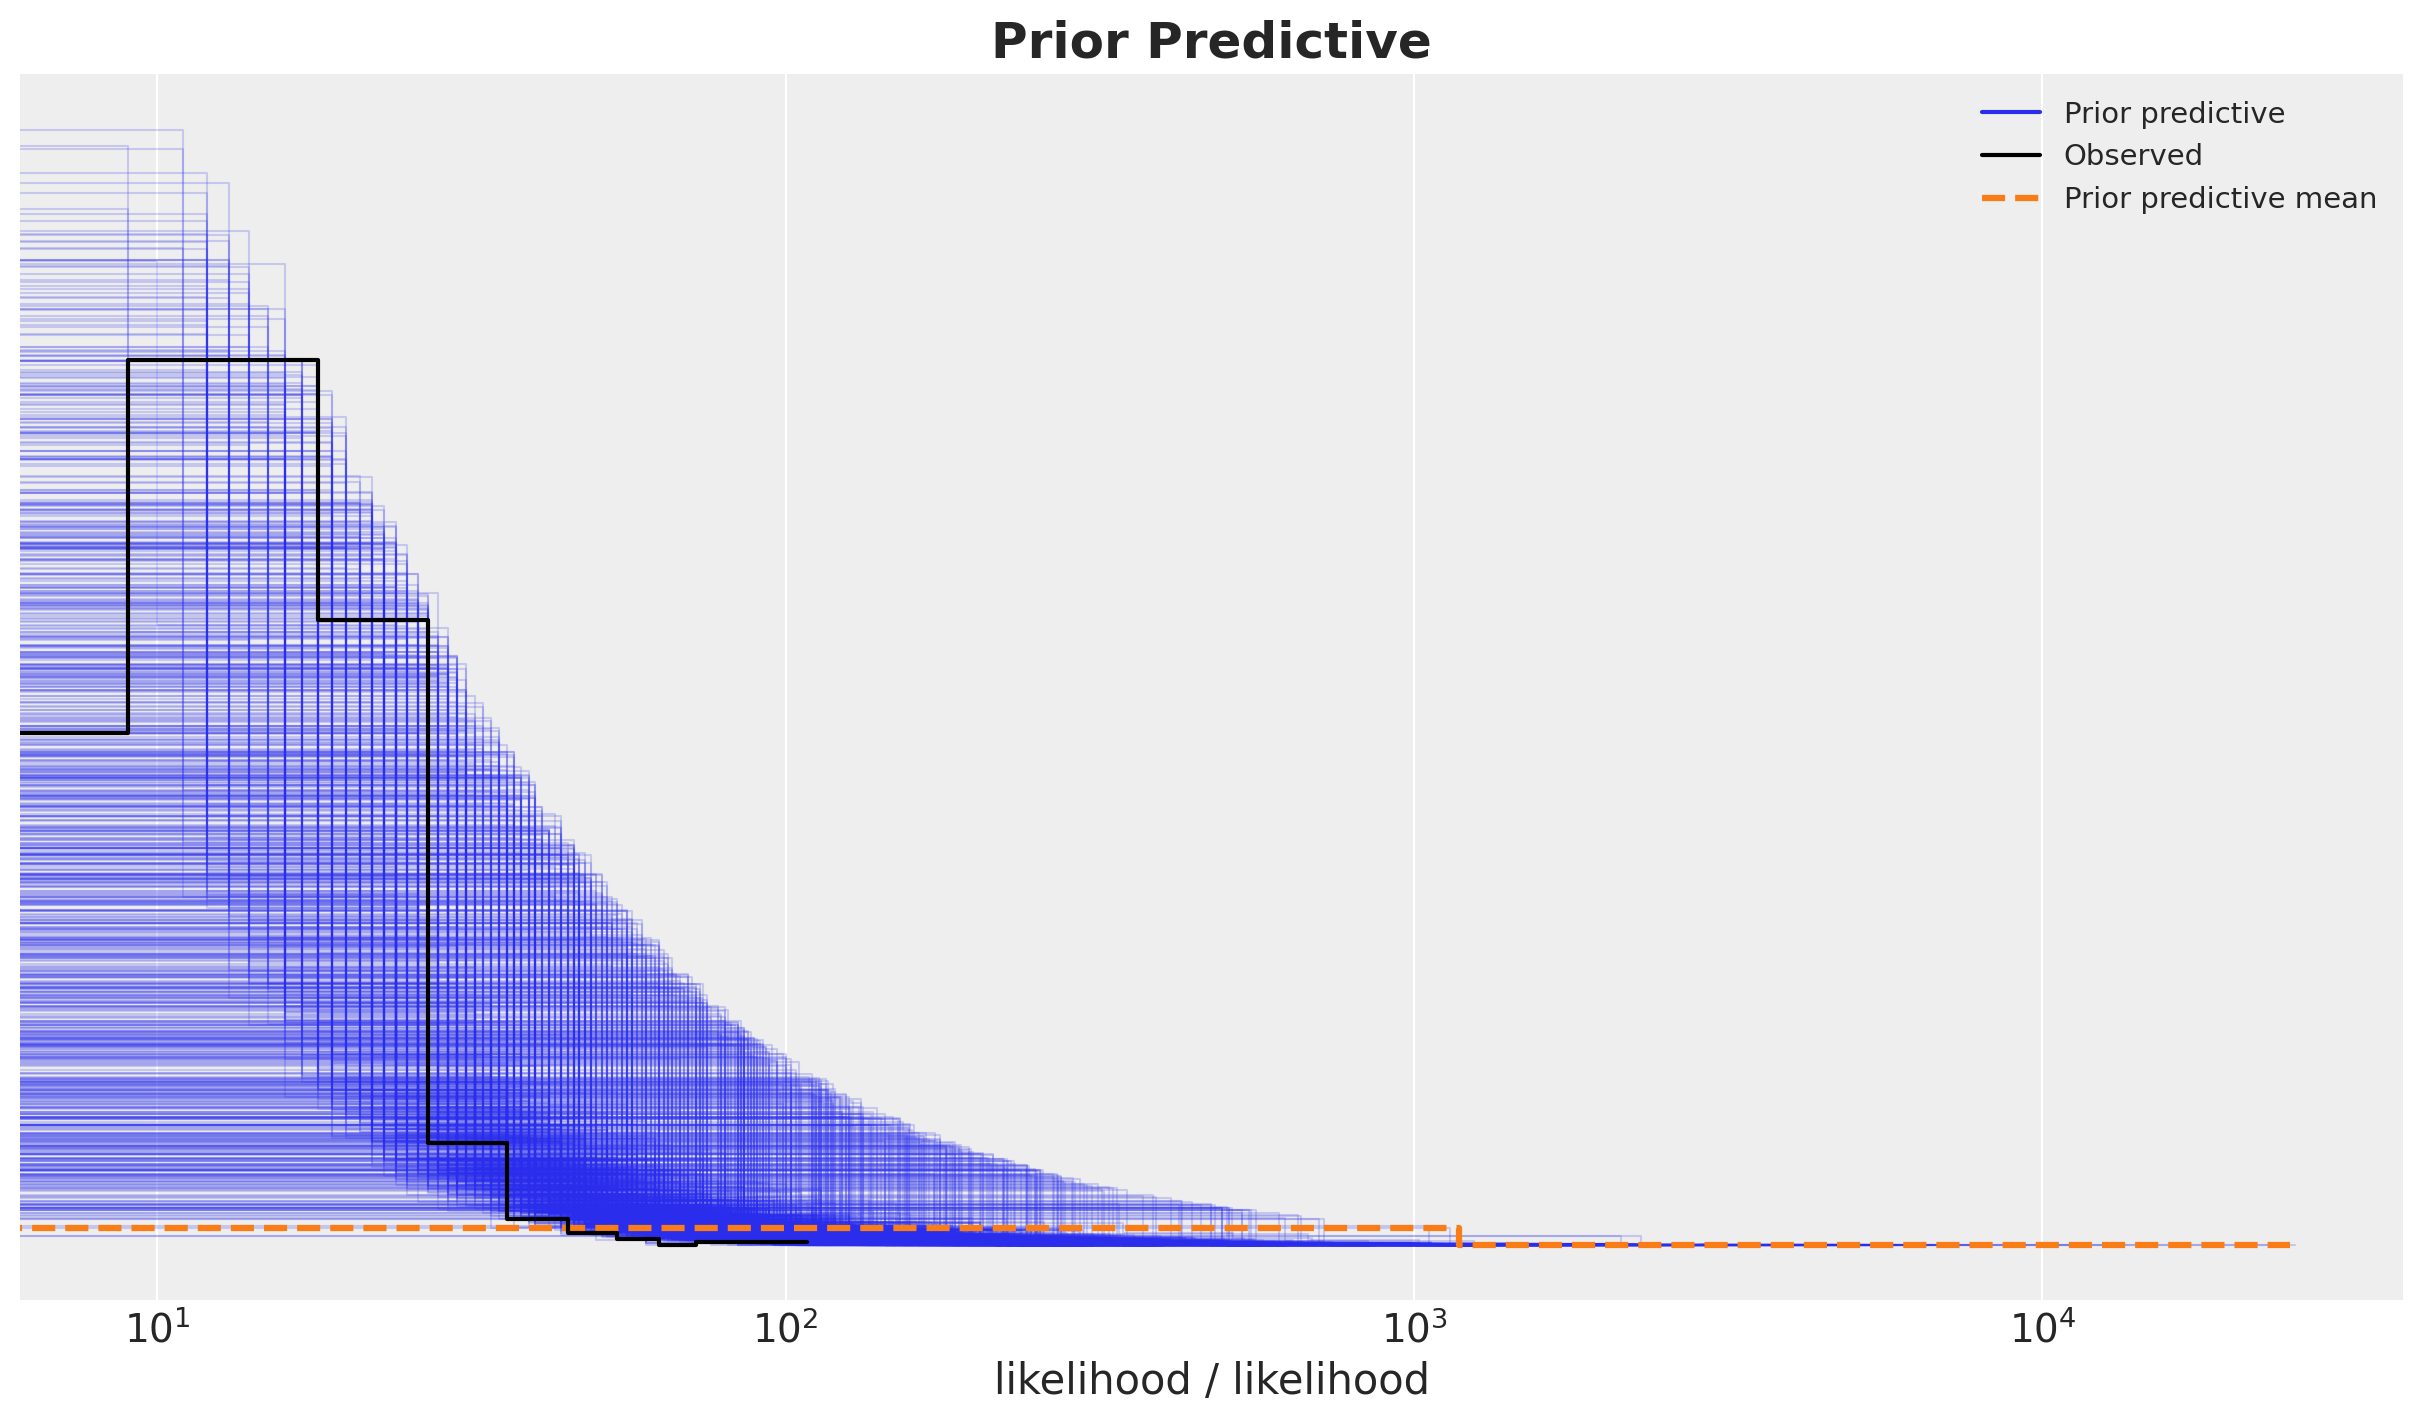

In [14]:
fig, ax = plt.subplots()
az.plot_ppc(data=prior_predictive, group="prior", kind="kde", ax=ax)
ax.set_title(label="Prior Predictive", fontsize=18, fontweight="bold")
ax.set(xscale="log")

Overall the prior predictive looks reasonable.

## Model Fitting

The model takes around $10$ minutes to fit (Mac Book Pro, Intel Core i7).

In [15]:
with model:
    idata = pm.sample(
        tune=1_000,
        target_accept=0.90,
        draws=3_000,
        chains=4,
        random_seed=rng,
    )
    posterior_predictive = pm.sample_posterior_predictive(trace=idata, random_seed=rng)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [power_minus, power_plus, sigma_ell_is_release_minus, sigma_ell_is_release_plus, sigma_is_release, ell_is_release_minus, ell_is_release_plus, beta_is_release, inv_alpha_lam, inv_alpha]
>PGBART: [bart_mu_log]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 656 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [likelihood]


## Diagnostics

We look into the model diagnostics. First we check divergences:

In [16]:
idata["sample_stats"]["diverging"].sum().item()

0

No divergences! Let's look into additional diagnostics:

In [17]:
var_names = [
    "power_minus",
    "power_plus",
    "sigma_is_release",
    "sigma_ell_is_release_minus",
    "sigma_ell_is_release_plus",
    "beta_is_release",
    "ell_is_release_minus",
    "ell_is_release_plus",
    "inv_alpha_lam",
    "inv_alpha",
    "alpha",
]

az.summary(data=idata, var_names=var_names, round_to=3)

mean          sd     hdi_3%  \
power_minus                           0.298       0.028      0.246   
power_plus                            0.252       0.020      0.215   
sigma_is_release                    102.876      42.193     46.924   
sigma_ell_is_release_minus            0.676       0.304      0.267   
sigma_ell_is_release_plus             1.975       0.920      0.740   
beta_is_release[iphone_11]           87.811       7.197     74.774   
beta_is_release[iphone_12]          104.559       8.481     89.382   
beta_is_release[iphone_13]           71.477       6.613     58.896   
beta_is_release[iphone_14]           77.189       7.859     62.536   
ell_is_release_minus[iphone_11]       0.306       0.092      0.090   
ell_is_release_minus[iphone_12]       0.637       0.056      0.536   
ell_is_release_minus[iphone_13]       0.508       0.054      0.405   
ell_is_release_minus[iphone_14]       0.596       0.061      0.483   
ell_is_release_plus[iphone_11]        1.621       0.165      1.323   
ell_is_release_plus[iphone_12]        1.240       0.108      1.047   
ell_is_release_plus[iphone_13]        1.653       0.164      1.358   
ell_is_release_plus[iphone_14]        1.434       0.151      1.148   
inv_alpha_lam                      1063.267     343.859    455.498   
inv_alpha[iphone_11]                  0.000       0.000      0.000   
inv_alpha[iphone_12]                  0.000       0.000      0.000   
inv_alpha[iphone_13]                  0.000       0.000      0.000   
inv_alpha[iphone_14]                  0.000       0.000      0.000   
alpha[iphone_11]                 145142.927  323221.101  14576.774   
alpha[iphone_12]                  74385.878  189051.386   5906.571   
alpha[iphone_13]                  44040.603   74711.095   4282.518   
alpha[iphone_14]                  15155.624   24059.611   1308.656   

                                    hdi_97%  mcse_mean   mcse_sd   ess_bulk  \
power_minus                           0.352      0.001     0.000   2391.351   
power_plus                            0.288      0.002     0.001     86.111   
sigma_is_release                    180.339      0.490     0.368  10416.997   
sigma_ell_is_release_minus            1.206      0.004     0.003   8418.883   
sigma_ell_is_release_plus             3.520      0.011     0.009   9682.738   
beta_is_release[iphone_11]          101.641      0.109     0.077   4319.084   
beta_is_release[iphone_12]          120.857      0.109     0.077   6011.804   
beta_is_release[iphone_13]           83.784      0.097     0.068   4645.736   
beta_is_release[iphone_14]           91.975      0.110     0.078   5044.312   
ell_is_release_minus[iphone_11]       0.443      0.003     0.002    887.354   
ell_is_release_minus[iphone_12]       0.743      0.001     0.001   2138.258   
ell_is_release_minus[iphone_13]       0.610      0.002     0.001   1283.886   
ell_is_release_minus[iphone_14]       0.711      0.002     0.001   1061.666   
ell_is_release_plus[iphone_11]        1.932      0.004     0.003   1851.762   
ell_is_release_plus[iphone_12]        1.450      0.002     0.002   2247.391   
ell_is_release_plus[iphone_13]        1.965      0.003     0.002   2443.428   
ell_is_release_plus[iphone_14]        1.703      0.003     0.002   2339.363   
inv_alpha_lam                      1731.624      2.941     2.080  12516.787   
inv_alpha[iphone_11]                  0.000      0.000     0.000  11882.618   
inv_alpha[iphone_12]                  0.000      0.000     0.000   9734.909   
inv_alpha[iphone_13]                  0.000      0.000     0.000  11053.589   
inv_alpha[iphone_14]                  0.000      0.000     0.000  11624.208   
alpha[iphone_11]                 364749.684   4811.220  3442.385  11882.618   
alpha[iphone_12]                 193317.310   2613.356  1848.025   9734.909   
alpha[iphone_13]                 116911.536    995.960   704.287  11053.589   
alpha[iphone_14]                  40757.582    369.597   269.143  11624.208   

              

Overall, it looks fine. 

Text(0.5, 0.98, 'Model Trace')

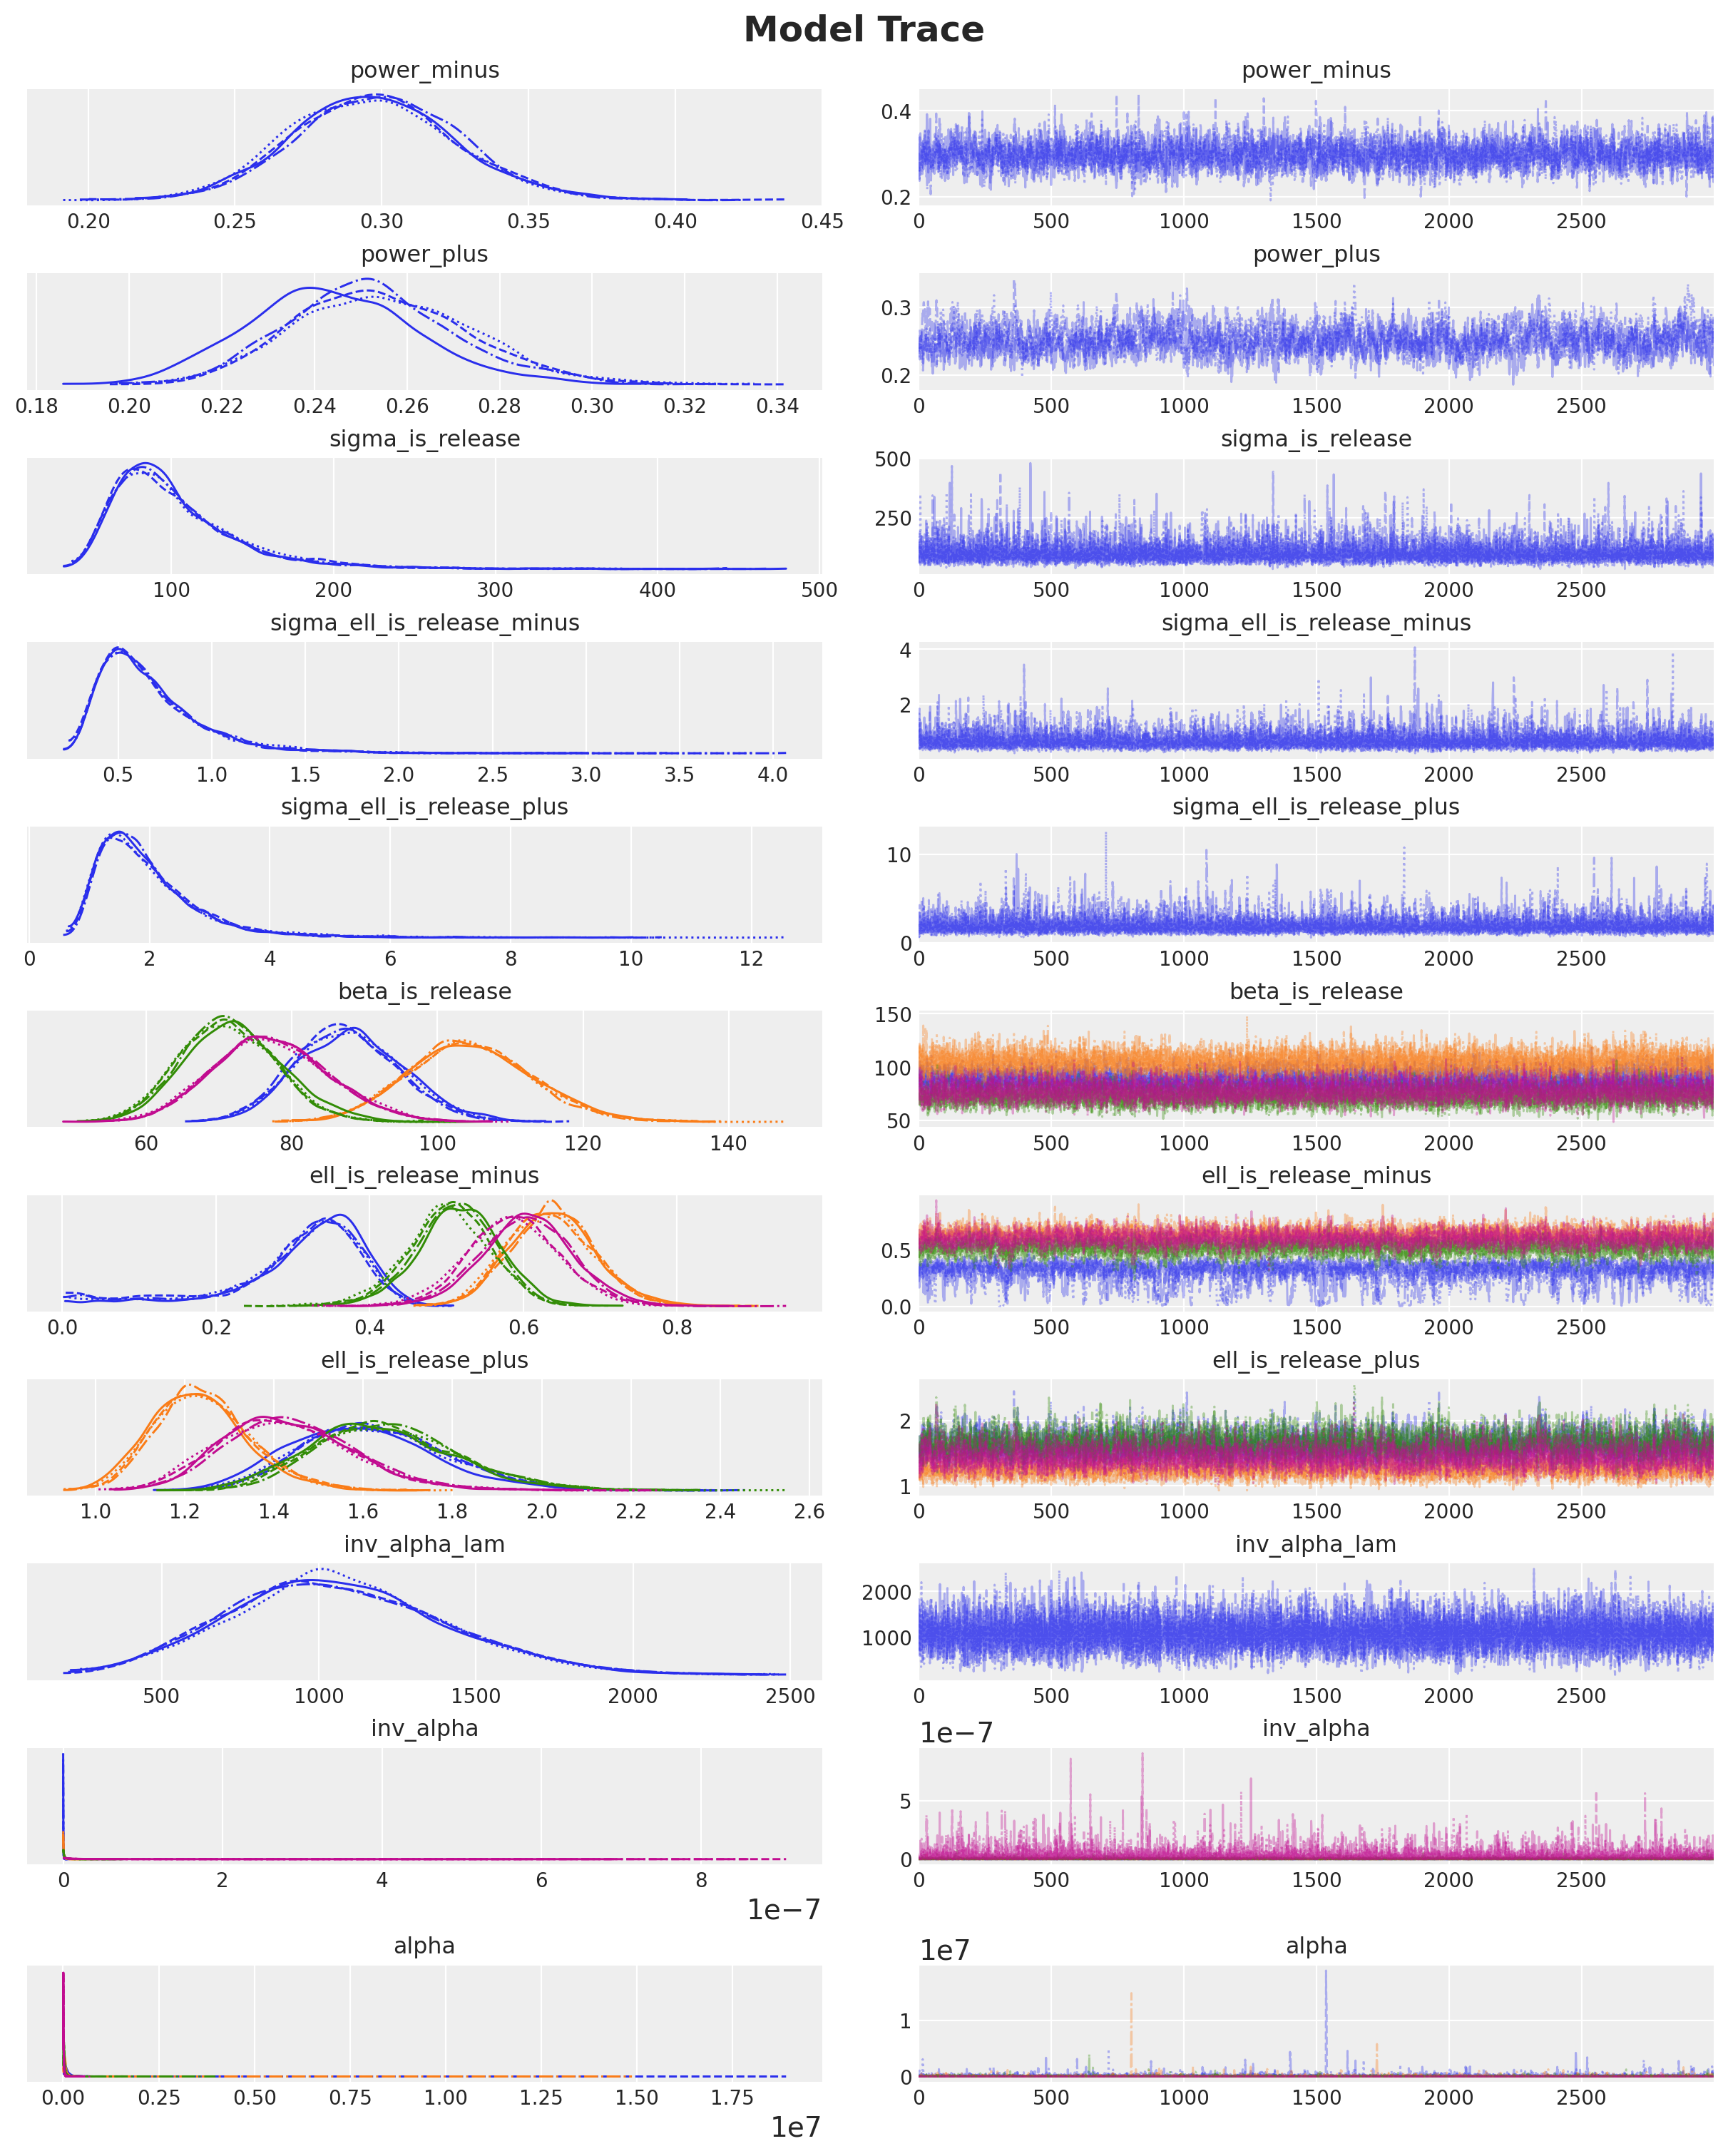

In [18]:
axes = az.plot_trace(
    data=idata,
    var_names=var_names,
    compact=True,
    backend_kwargs={"figsize": (12, 15), "layout": "constrained"},
)
plt.gcf().suptitle("Model Trace", fontsize=18, fontweight="bold")

## Posterior Predictive

We now look into the posterior predictive distribution:

<Axes: xlabel='likelihood / likelihood'>

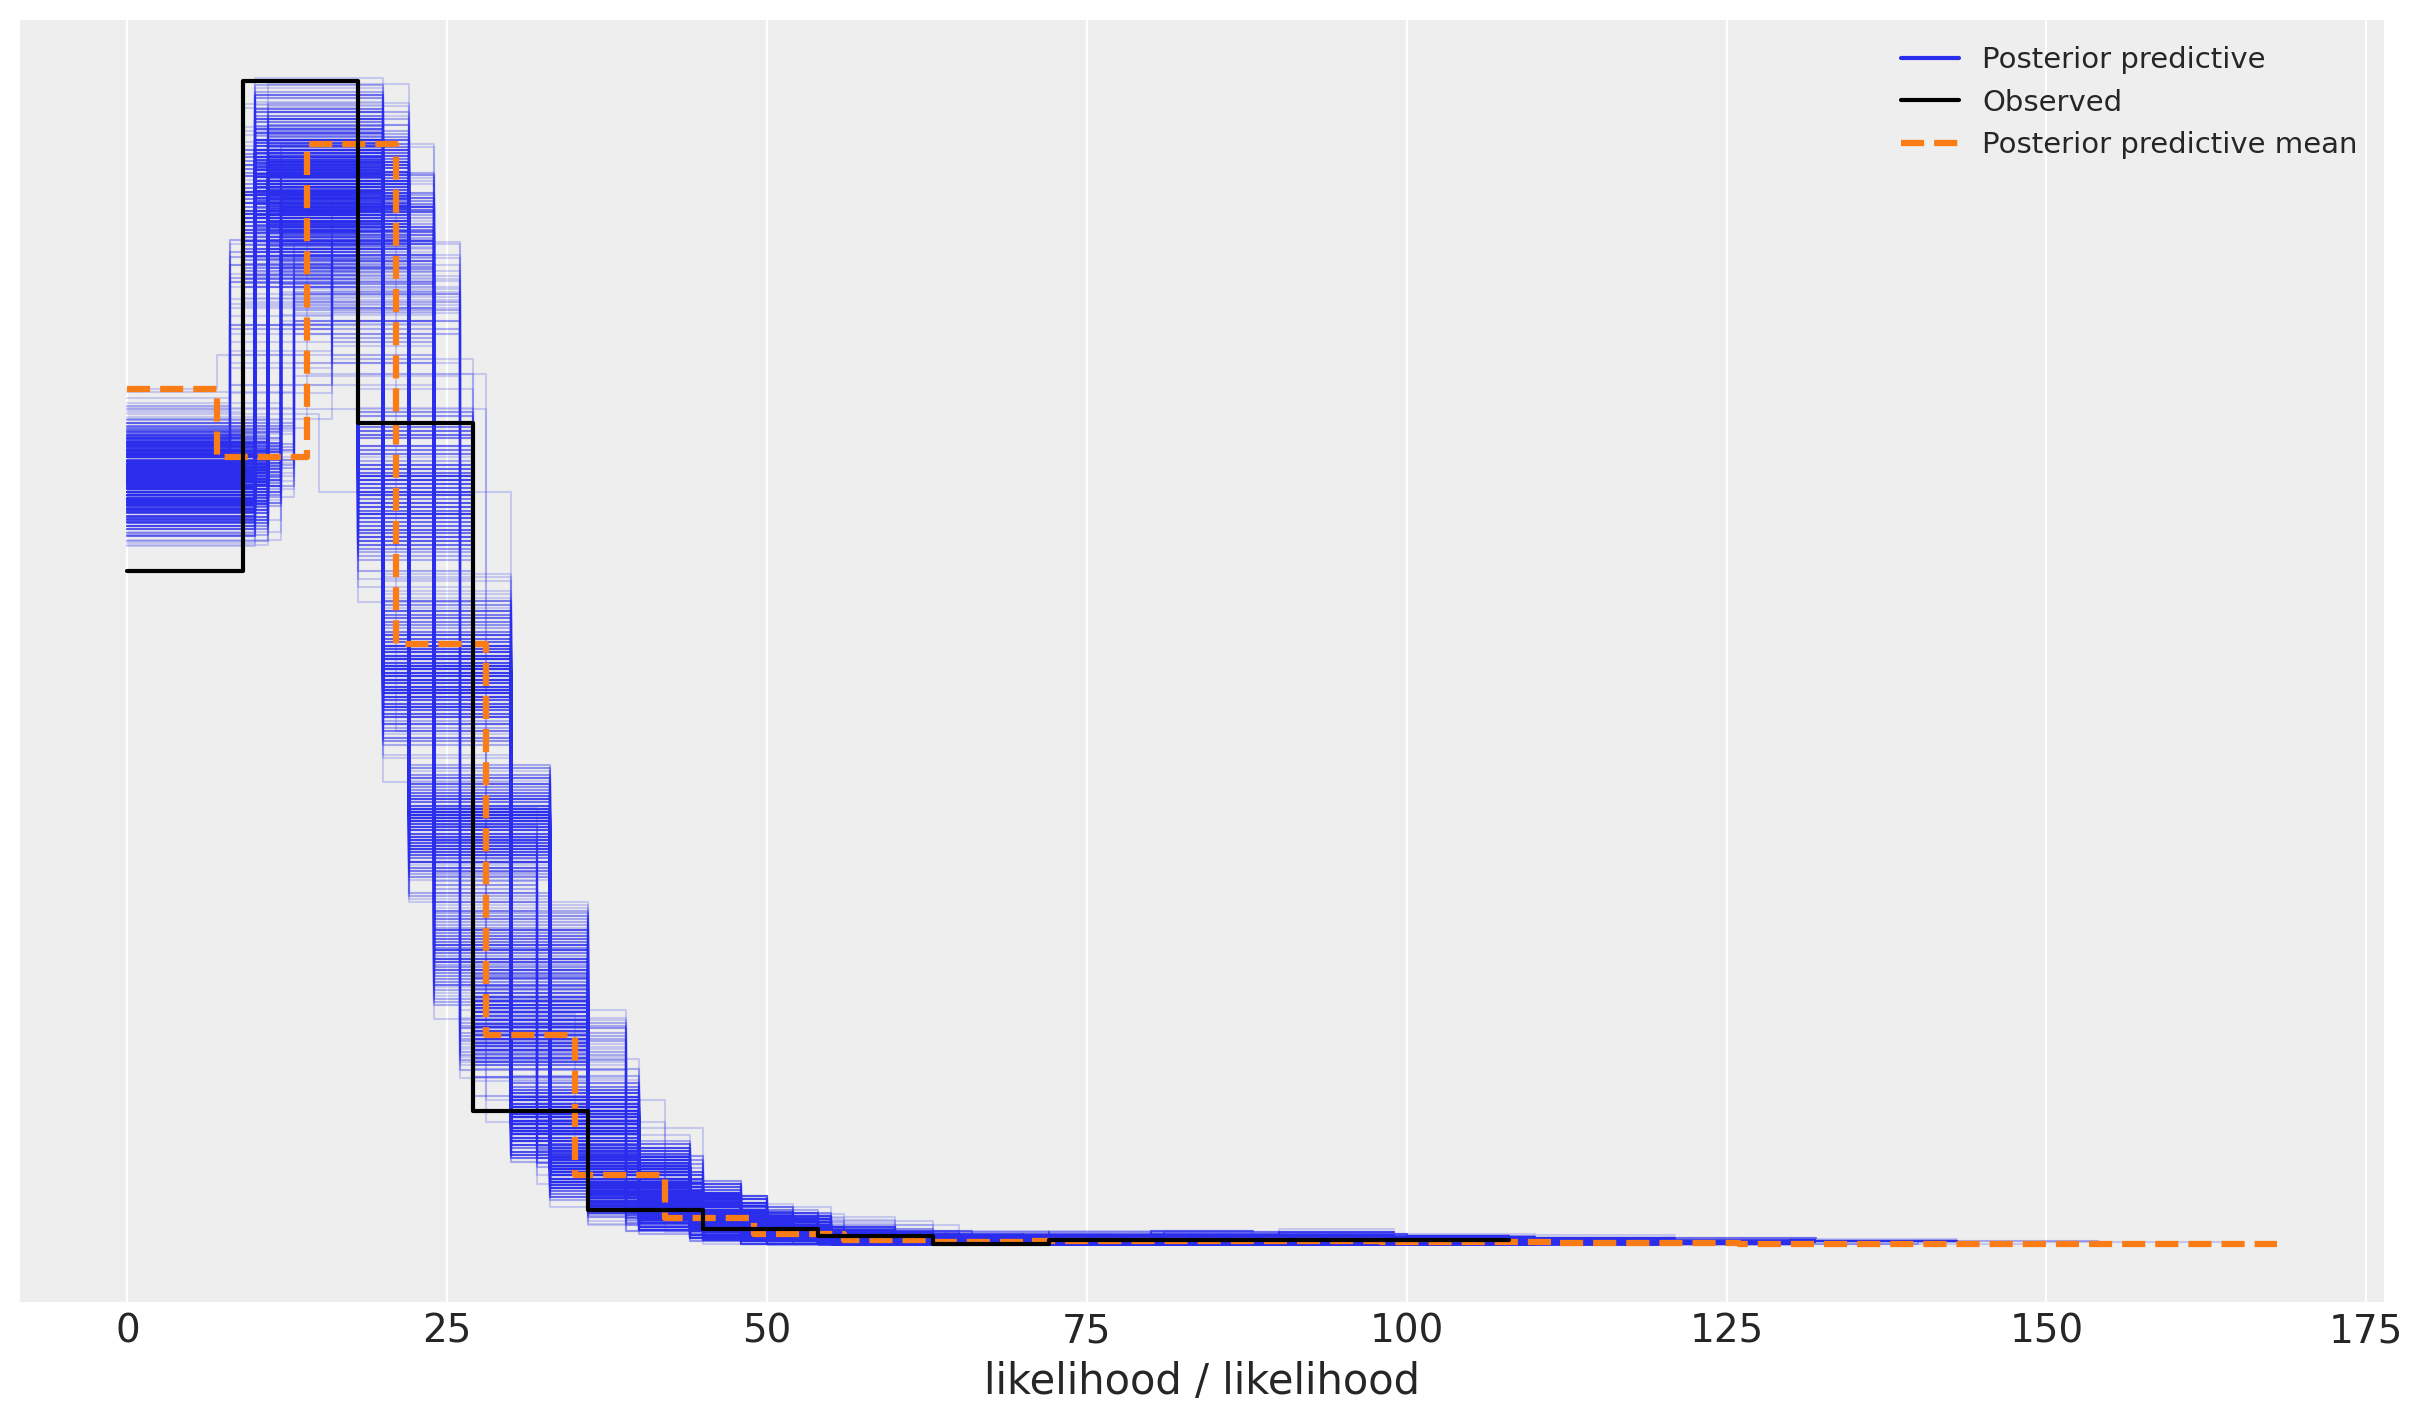

In [19]:
az.plot_ppc(
    data=posterior_predictive,
    num_pp_samples=1_000,
    observed_rug=True,
    random_seed=seed,
)

It looks the model has captured most of the variance from the data.

We can now look for each model separately:

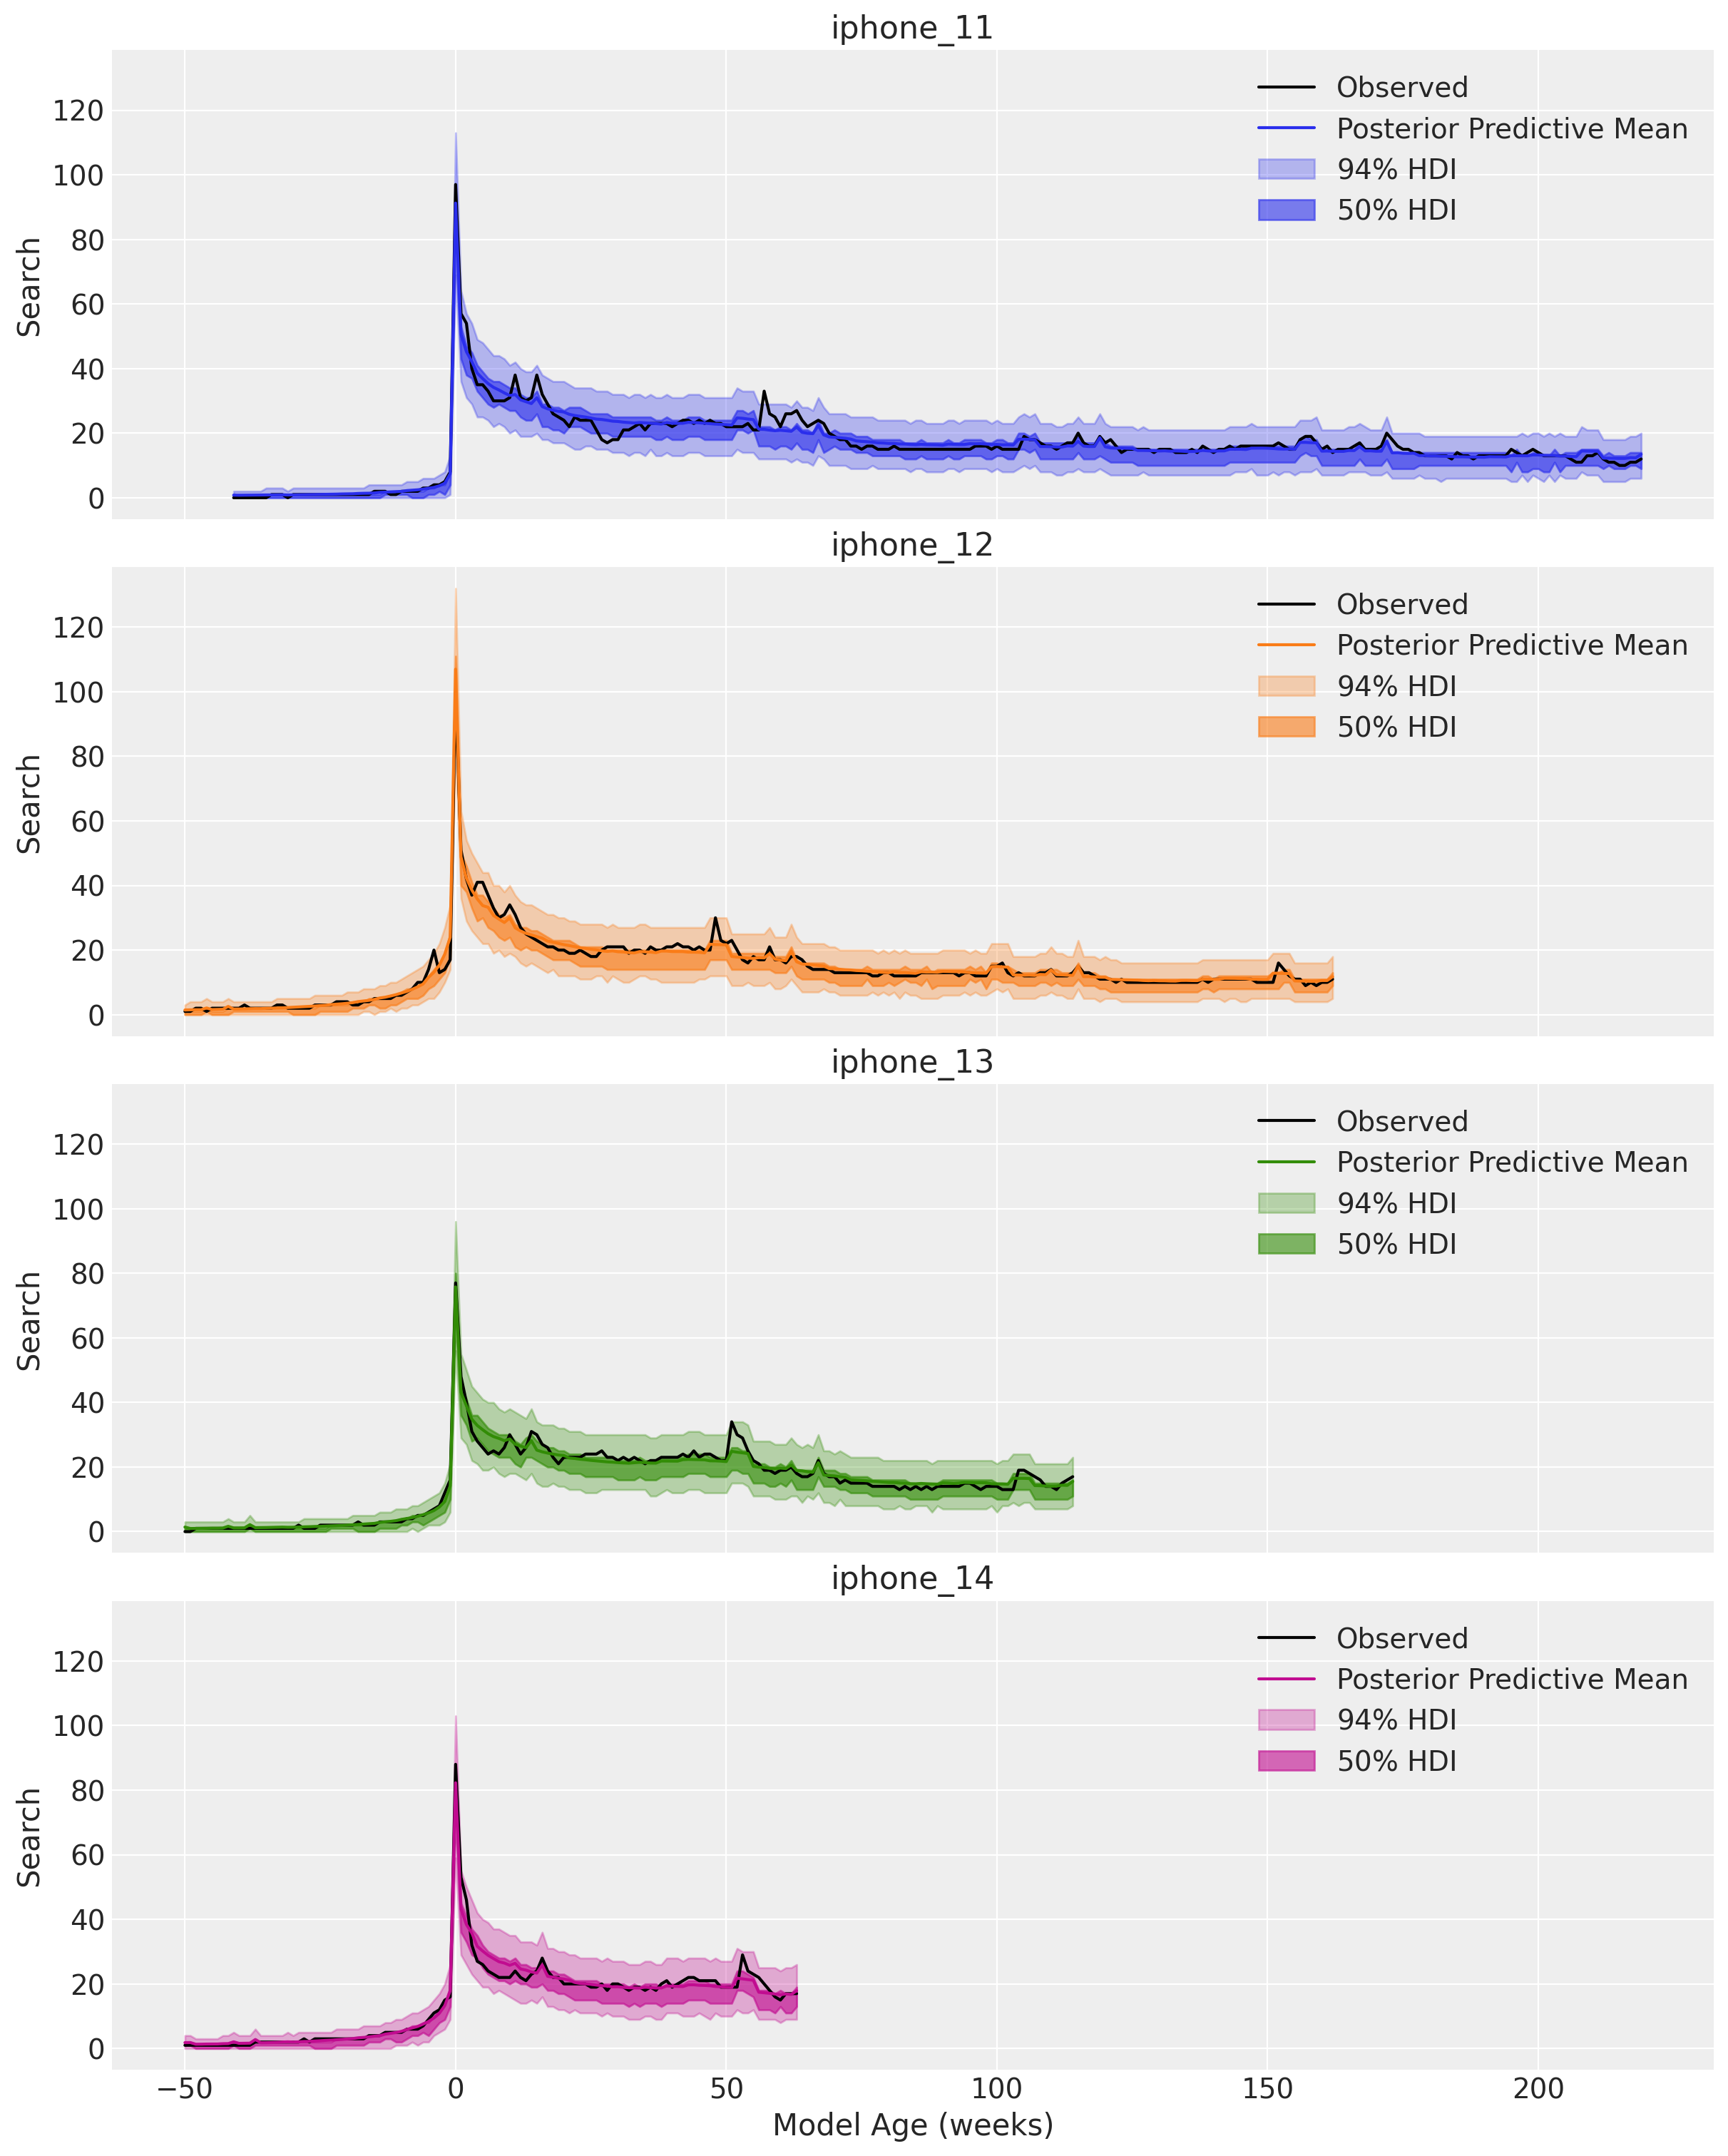

In [20]:
fig, axes = plt.subplots(
    nrows=train_iphone_model.size,
    ncols=1,
    sharex=True,
    sharey=True,
    figsize=(12, 15),
    layout="constrained",
)

for i, iphone_model in enumerate(train_iphone_model):
    ax = axes[i]

    condition = train_df["model"] == iphone_model
    temp_df = train_df[condition]
    temp_likelihood = posterior_predictive["posterior_predictive"]["likelihood"][
        :, :, condition.to_numpy()
    ]

    sns.lineplot(
        data=temp_df,
        x="model_age",
        y="search",
        color="black",
        label="Observed",
        ax=ax,
    )
    sns.lineplot(
        x=temp_df["model_age"],
        y=temp_likelihood.mean(dim=("chain", "draw")),
        color=f"C{i}",
        label="Posterior Predictive Mean",
        ax=ax,
    )
    az.plot_hdi(
        x=temp_df["model_age"],
        y=temp_likelihood,
        hdi_prob=0.94,
        color=f"C{i}",
        smooth=False,
        fill_kwargs={"alpha": 0.3, "label": r"$94\%$ HDI"},
        ax=ax,
    )
    az.plot_hdi(
        x=temp_df["model_age"],
        y=temp_likelihood,
        hdi_prob=0.50,
        color=f"C{i}",
        smooth=False,
        fill_kwargs={"alpha": 0.6, "label": r"$50\%$ HDI"},
        ax=ax,
    )
    ax.legend(loc="upper right")
    ax.set(title=iphone_model, xlabel="Model Age (weeks)", ylabel="Search")

We indeed see we the model has captures the release peak, the decay and the yearly seasonality 🙌!

## Life Cycle Components

We now split the posterior predictive mean into the release peak and decay components:

Text(0.5, 1.0, 'Google Trends for iPhone Models (Worldwide)')

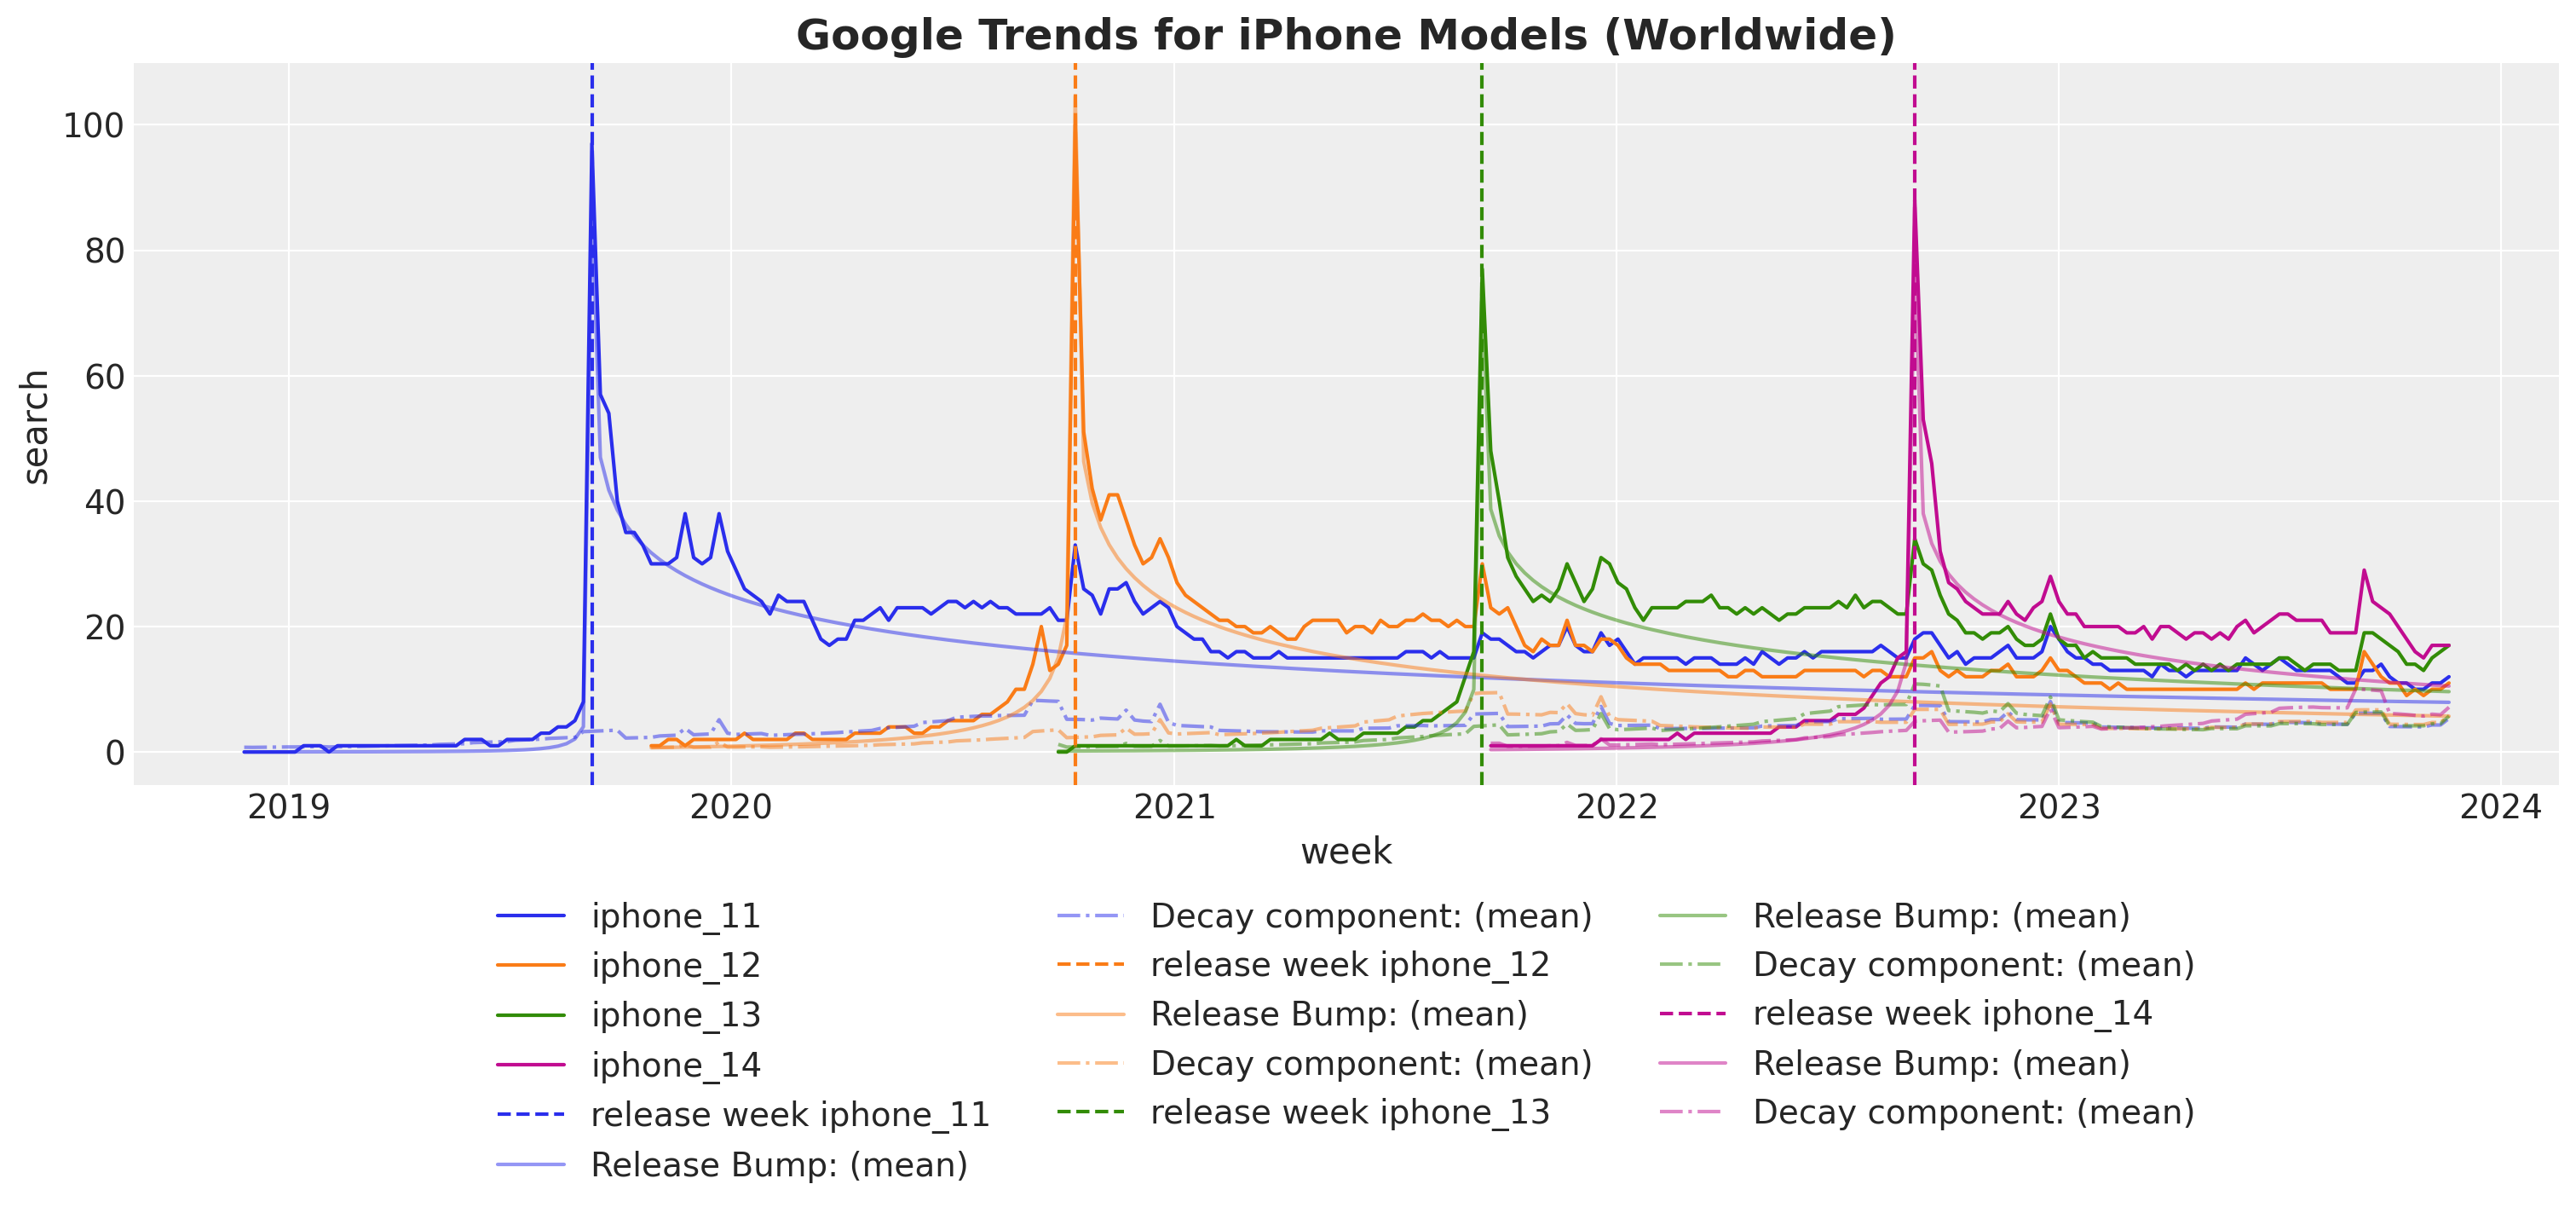

In [21]:
fig, ax = plt.subplots(figsize=(15, 7))

sns.lineplot(
    data=train_df,
    x="week",
    y="search",
    hue="model",
    ax=ax,
)

for i, iphone_model in enumerate(
    release_dates_df.query(f"model != '{test_model}'")["model"]
):
    condition = (train_df["model"] == iphone_model).to_numpy()

    release_week = release_dates_df.query(f"model == '{iphone_model}'")[
        "release_week"
    ].item()

    ax.axvline(
        release_week,
        color=f"C{i}",
        linestyle="--",
        label=f"release week {iphone_model}",
    )

    sns.lineplot(
        x=train_df["week"][condition],
        y=idata["posterior"]["is_release_bump"].mean(dim=("chain", "draw"))[condition],
        color=f"C{i}",
        alpha=0.5,
        label="Release Bump: (mean)",
        ax=ax,
    )

    sns.lineplot(
        x=train_df["week"][condition],
        y=np.exp(
            idata["posterior"]["bart_mu_log"].mean(dim=("chain", "draw"))[condition]
        ),
        color=f"C{i}",
        alpha=0.5,
        linestyle="-.",
        label="Decay component: (mean)",
        ax=ax,
    )

ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.12), ncol=3)
ax.set_title(
    label="Google Trends for iPhone Models (Worldwide)", fontsize=18, fontweight="bold"
)

Most of the variance is explained by the release Gaussian bump components. The decay component acs as a small collection over the initial peak decay.

We can decompose further de decay component by looking into the partial dependence plots:

Text(0.5, 1.05, 'Partial Dependency Plots (PDP)')

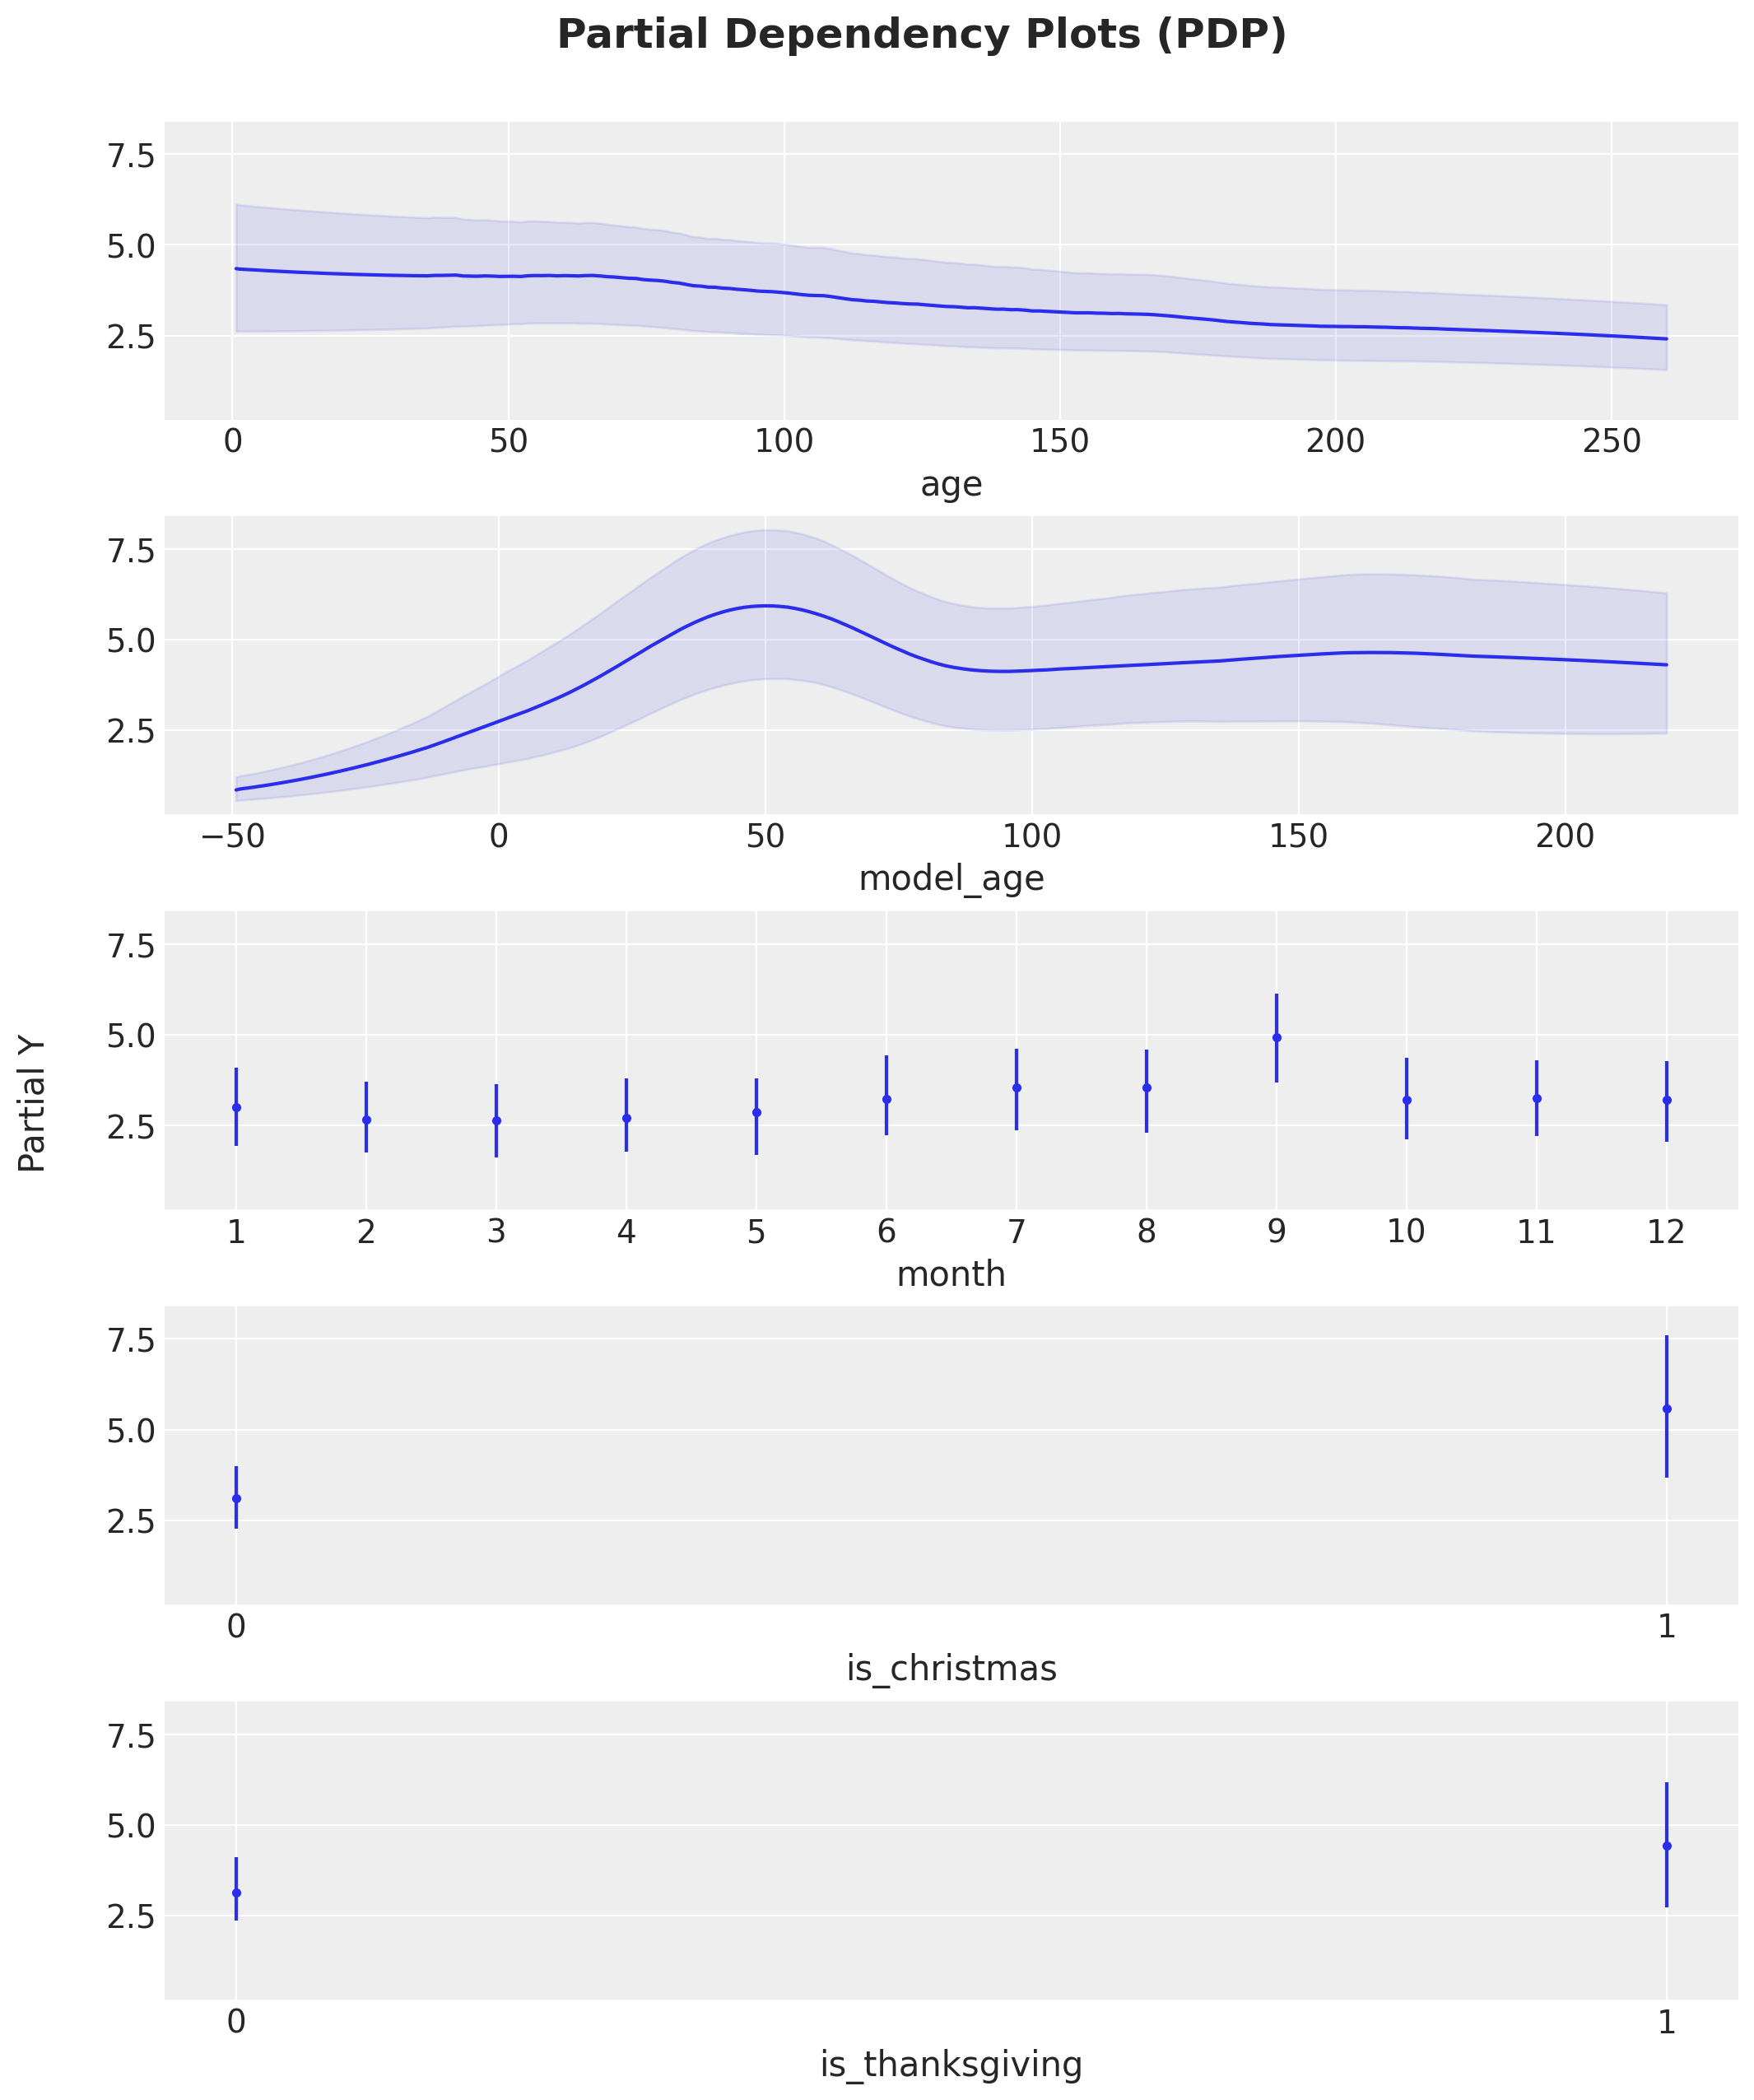

In [22]:
axes = pmb.plot_pdp(
    bartrv=bart_mu_log,
    X=x_train,
    Y=train_search,
    func=np.exp,
    xs_interval="insample",
    samples=1_000,
    grid="long",
    color="C0",
    color_mean="C0",
    var_discrete=[2, 3, 4],
    figsize=(10, 12),
    random_seed=seed,
)
plt.gcf().suptitle(
    "Partial Dependency Plots (PDP)",
    fontsize=18,
    fontweight="bold",
    y=1.05,
)

Here are some remarks from these partial dependence plots:
- Overall, the contribution of the decay component is small 9expected from the plot above).
- The `age`'s contribution decays monotonically.
- The variable `model_age` presents a bump around week $50$, which seems to be be related to the release of the next iPhone model. We could add this feature to the model to capture this behavior.
- We see a mild seasonality contribution from the `month` variable, attaining a maximum around September when the new iPhone models are usually released.
- We also a mild contribution from the holidays variable. A better encoding would be a multiplicative interaction with the model age.

## Out-of-Sample Predictions

We now generate out of sample prediction for the unseen iPhone model:

In [23]:
test_obs = test_df.index.to_numpy()
test_iphone_model_idx, test_iphone_model = test_df["model"].factorize(sort=True)
test_month_idx, test_month = test_df["month"].factorize(sort=True)
test_age = test_df["age"].to_numpy()
test_model_age = test_df["model_age"].to_numpy()
test_is_release = test_df["is_release"].to_numpy()
x_test = test_df[features]
test_search = test_df["search"].to_numpy()

In [24]:
with model:
    pm.set_data(
        new_data={
            "iphone_model_idx_data": test_iphone_model_idx,
            "model_age_data": test_model_age,
            "x_data": x_test,
            "search_data": np.ones_like(test_search),  # Dummy data to make coords work!
            # We are not using this at prediction time!
        },
        coords={"iphone_model": test_iphone_model, "obs": test_obs},
    )
    idata.extend(
        pm.sample_posterior_predictive(
            trace=idata,
            var_names=["is_release_bump", "bart_mu_log", "likelihood"],
            idata_kwargs={
                "coords": {"iphone_model": test_iphone_model, "obs": test_obs}
            },
            random_seed=rng,
        )
    )

Sampling: [bart_mu_log, likelihood]


Finally, we plot the posterior predictive distribution for the unseen iPhone model:

[Text(0.5, 1.0, 'iphone_15'),
 Text(0.5, 0, 'Model Age (weeks)'),
 Text(0, 0.5, 'Search')]

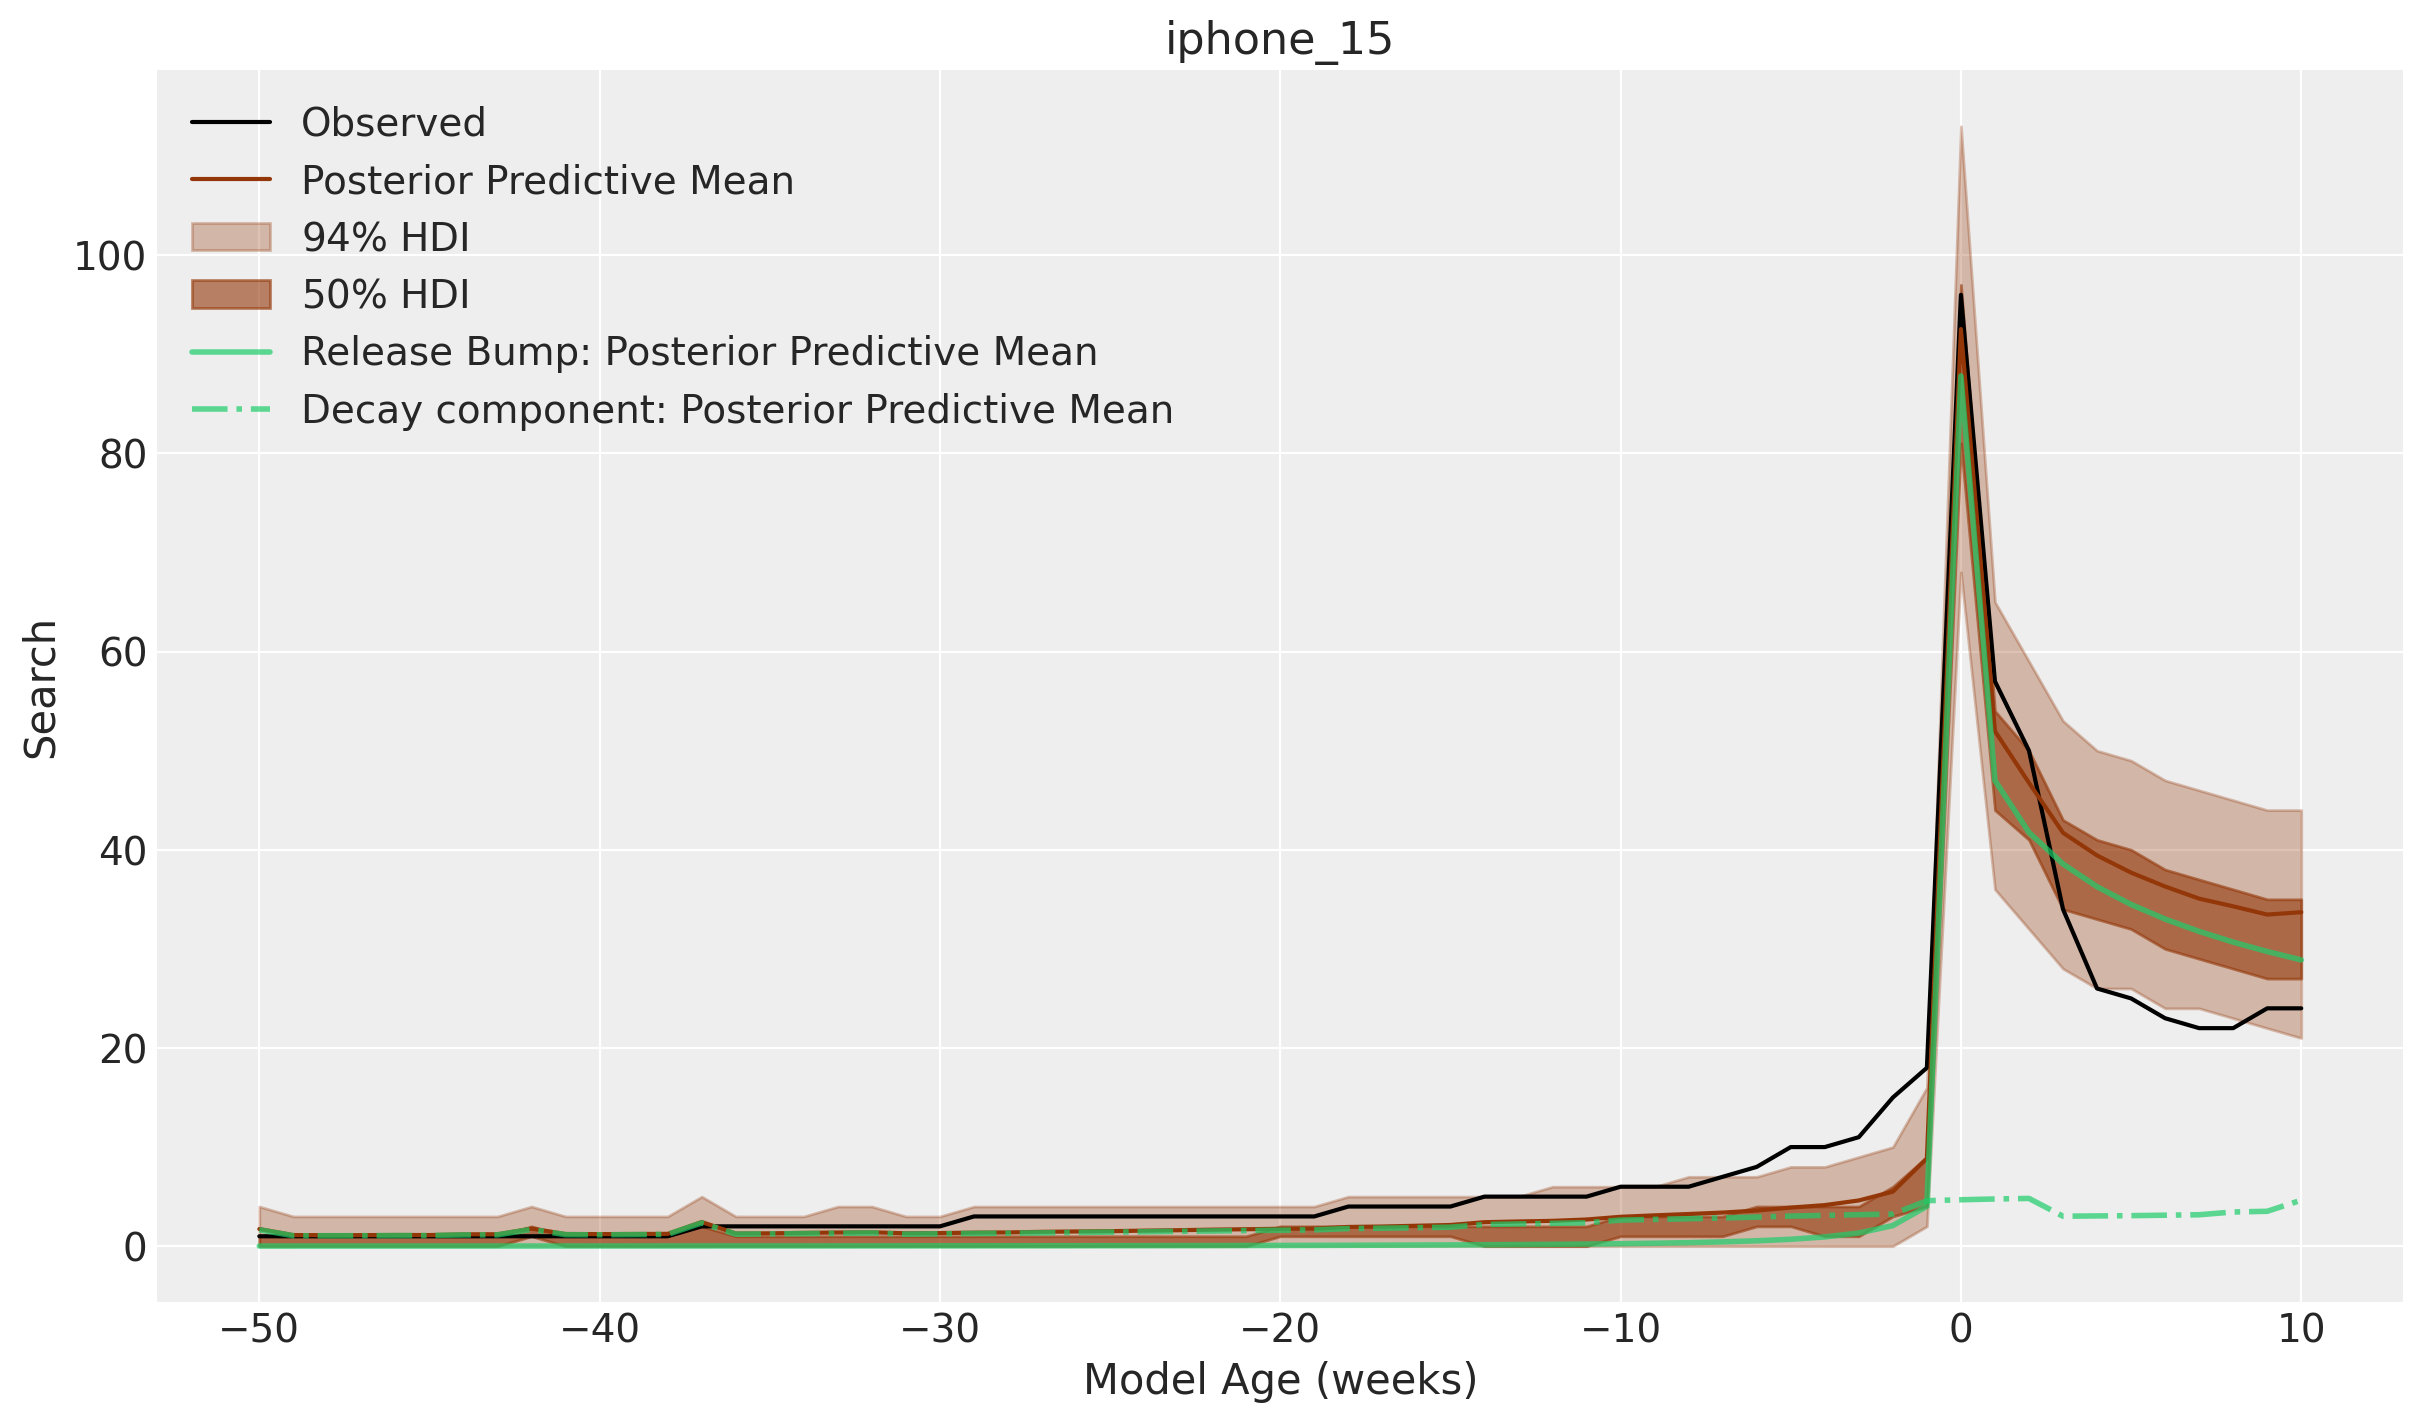

In [25]:
fig, ax = plt.subplots()

test_likelihood = idata["posterior_predictive"]["likelihood"]

i = 4

sns.lineplot(
    data=test_df,
    x="model_age",
    y="search",
    color="black",
    label="Observed",
    ax=ax,
)
sns.lineplot(
    x=test_df["model_age"],
    y=test_likelihood.mean(dim=("chain", "draw")),
    color=f"C{i}",
    label="Posterior Predictive Mean",
    ax=ax,
)
az.plot_hdi(
    x=test_df["model_age"],
    y=test_likelihood,
    hdi_prob=0.94,
    color=f"C{i}",
    smooth=False,
    fill_kwargs={"alpha": 0.3, "label": r"$94\%$ HDI"},
    ax=ax,
)
az.plot_hdi(
    x=test_df["model_age"],
    y=test_likelihood,
    hdi_prob=0.50,
    color=f"C{i}",
    smooth=False,
    fill_kwargs={"alpha": 0.6, "label": r"$50\%$ HDI"},
    ax=ax,
)
sns.lineplot(
    x=test_df["model_age"],
    y=idata["posterior_predictive"]["is_release_bump"].mean(dim=("chain", "draw")),
    color="C7",
    linewidth=2,
    alpha=0.7,
    label="Release Bump: Posterior Predictive Mean",
    ax=ax,
)
sns.lineplot(
    x=test_df["model_age"],
    y=np.exp(idata["posterior_predictive"]["bart_mu_log"].mean(dim=("chain", "draw"))),
    color="C7",
    linewidth=2,
    linestyle="-.",
    alpha=0.7,
    label="Decay component: Posterior Predictive Mean",
    ax=ax,
)
ax.legend(loc="upper left")
ax.set(title=test_model, xlabel="Model Age (weeks)", ylabel="Search")

We see the model has captured the release peak and the decay within the $94\%$ HDI.In particular, the predicted peak maximum is very close to the observed one.

## Final Remarks

This example shows how to build a custom model for a family of products with similar life cycle structures. The model is flexible enough to capture the release peak and the long term decay. The model can be easily extended to other products and life cycle structures. Here we just illustrated some of the possibilities.